In [20]:
import cv2
from pathlib2 import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

#### Импорт данных

In [155]:
def read_data(mask):
    file_names = glob(str(mask))
    file_names.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    paths_to_images = []
    for file_name in file_names:
        path_to_image = file_name
        paths_to_images.append(path_to_image)
    df_all = pd.DataFrame({
        'file_path' : paths_to_images})
    return df_all

In [159]:
df_all = read_data(mask = Path(r'C:/nn/Task_Astrocytes/Task_Astrocytes')/'**'/'**'/'events'/'**.png')

In [160]:
def select_rows_by_value(df_all,  value_for_select):
    value_for_select = df_all[df_all.file_path.str.contains(f'{value_for_select}')]
    v_record_events = value_for_select[value_for_select.file_path.str.contains('event')]
    file_paths = v_record_events['file_path'].values
    return file_paths

In [163]:
file_paths = select_rows_by_value(df_all,  value_for_select='tser1')

6.6. двумерная гистограмма: для каждого пикселя количество моментов времени, когда он начинал гореть (то есть смена значения пикселя с 0 на 1).

In [168]:
def count_hist(file_paths):
    file_paths_as_list = file_paths[0].split('\\')
    title = file_paths_as_list[5]
    shape_hist = cv2.imread(str(file_paths[0]))
    shape_hist = cv2.cvtColor(shape_hist, cv2.COLOR_BGR2GRAY)
    array_for_hist = np.zeros(shape_hist.shape)
    for i in range(len(file_paths) - 1):
        one_image = cv2.imread(str(file_paths[i]))
        one_image_in_gray = cv2.cvtColor(one_image, cv2.COLOR_BGR2GRAY)
        one_image_in_gray[one_image_in_gray >= 1] = 1
        following_image = cv2.imread(str(file_paths[i+1]))
        following_image_in_gray = cv2.cvtColor(following_image, cv2.COLOR_BGR2GRAY)
        following_image_in_gray[following_image_in_gray >= 1] = 1
        difference = following_image_in_gray - one_image_in_gray
        difference[difference == 255] = 0
        array_for_hist = array_for_hist + difference
    return array_for_hist, title

In [171]:
def D2_histogfamm(array_for_hist, title):
    h, w = array_for_hist.shape[0], array_for_hist.shape[1]
    hist = plt.figure(figsize=(6.5,3.37))
    plt.title(f'{title}', fontsize=10)
    plt.gca().invert_yaxis()
    plt.plot([w - 71, w - 20], [h - 20, h - 20], color='w', linewidth=1)
    plt.text(w - 75, h - 25, '10 $\mu$m', color = 'w', style='italic', size='small')
    plt.imshow(array_for_hist, cmap='gray')
    cbar = plt.colorbar(label= "Количество загораний", orientation="vertical",shrink=.75)
    return hist

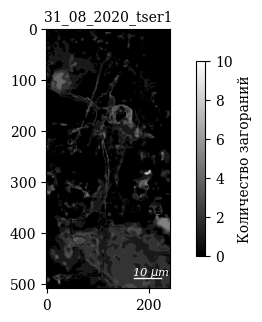

In [172]:
hist = D2_histogfamm(array_for_hist=count_hist(file_paths)[0], title = count_hist(file_paths)[1])

#### Визуализация зависимости площади самой большой области в зависимости от номера кадра.


In [173]:
def count_max_square(file_paths):
    squares_max = []
    for i in range(len(file_paths)):
        image = cv2.imread(str(file_paths[i]))
        image_in_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret,thresh_img = cv2.threshold(image_in_gray, 200, 255, cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        areas = []
        for j in range(len(contours)):
            area = cv2.contourArea(contours[j])
            size = area * (1/5.1) ** 2 # 5.1 pixel = 1 mkm
            areas.append(round(size, 3))
        max_area = max(areas)
        squares_max.append(max_area)    
    return squares_max

In [176]:
squares_max = count_max_square(file_paths)

In [178]:
def plot_square_to_time(squares_max, title):
    t = np.arange(0, len(squares_max)) / 2
    plt.rcParams['font.family'] = 'serif'
    PLOT = plt.figure(figsize=(6.5, 3.37), dpi=300.0)
    plt.rc('axes', titlesize=8)
    plt.title("Зависимость площади самой большой области от номера кадра ")
    plt.plot(t, squares_max, '#FF0055', linewidth=2, label=f'{title}')
    plt.ylabel('Площадь (S), $\mu$m$^2$')
    plt.legend()
    plt.xlabel('Время t, мин')
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.minorticks_on()
    minits = []
    for i in range(len(t)):
        if t[i] % 60 == 0:
            minits.append(int(t[i] // 60))
    plt.xticks (ticks=np.arange(min(t), max(t), 60.0), labels=minits)
    plt.show()
    return PLOT

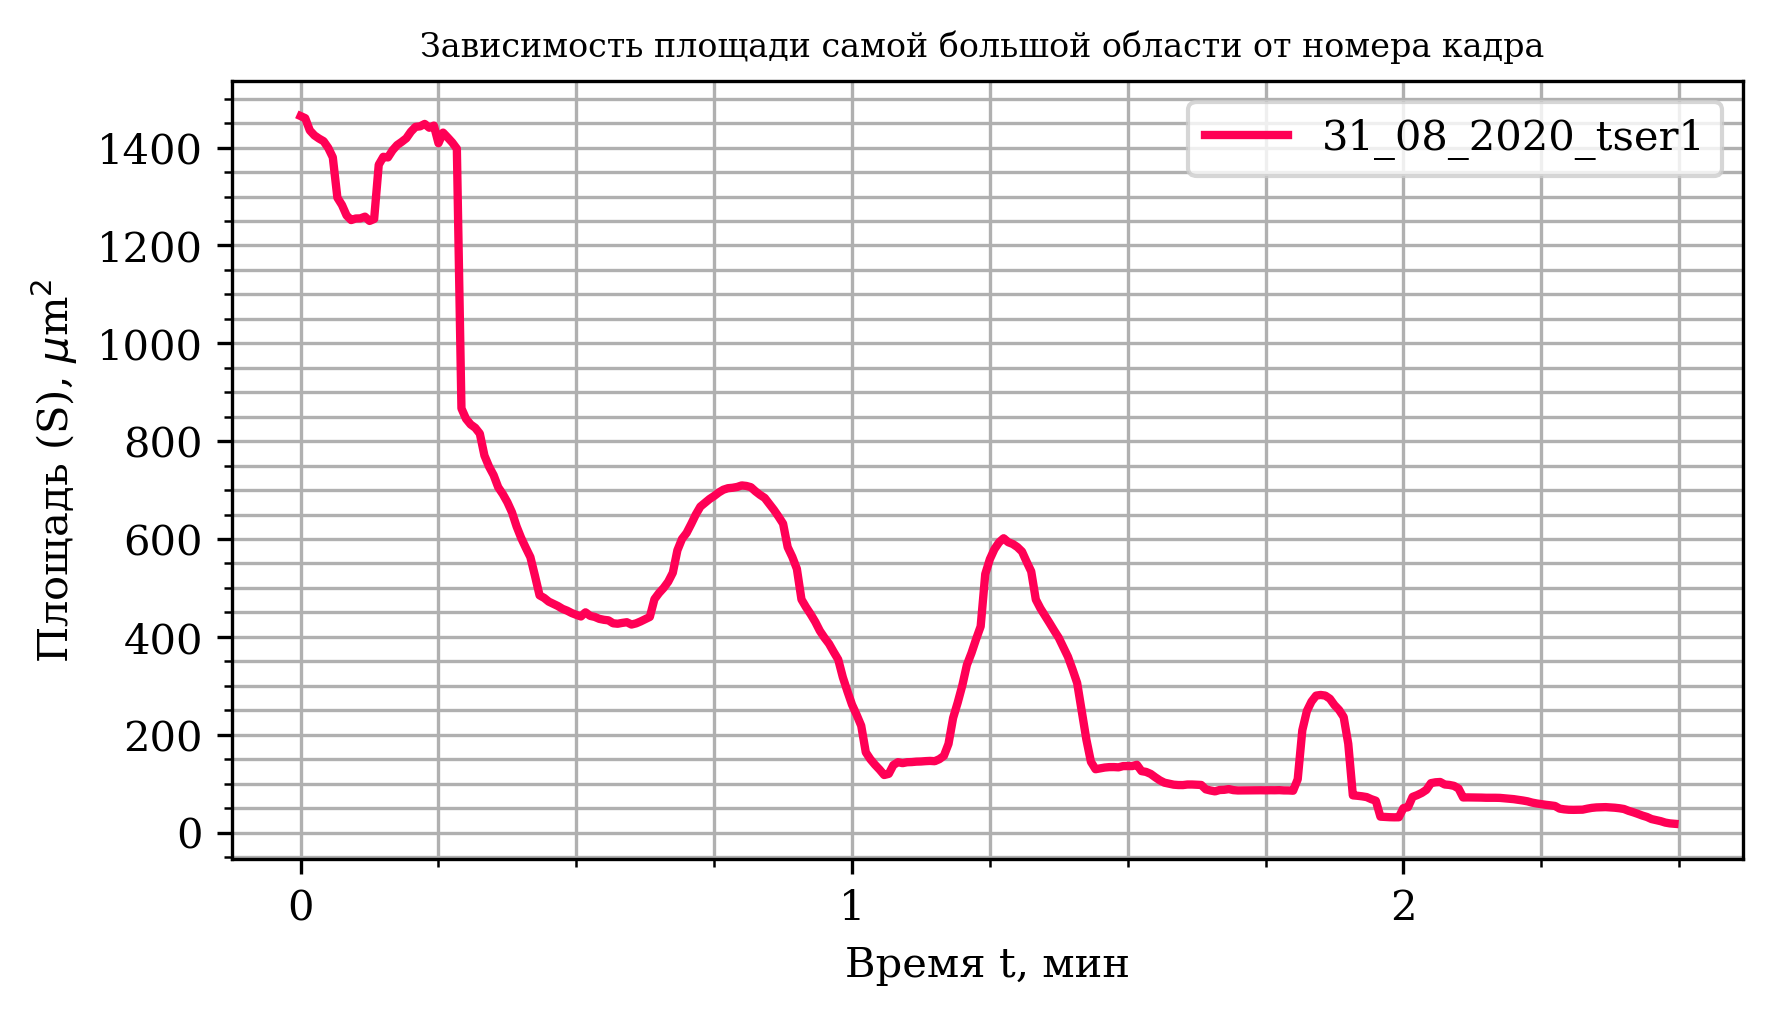

In [179]:
PLOT = plot_square_to_time(squares_max, title=count_hist(file_paths)[1])

#### Сохранение данных (из 6.9)

In [180]:
def save_table(squares_max, file_paths, data_dir_save):
    data_path = Path(data_dir_save)
    file_system_objects = file_paths[0].split('\\')
    title = file_system_objects[5]
    table_for_part = pd.DataFrame({
        'Square_max, кв. мкм': squares_max, 'file_path': file_paths})
    table_for_part.to_excel(data_path / f'{title}.xlsx', index=False)

In [183]:
data_dir_save = r'C:/Users/sibir/Desktop/results'
save_table(data_dir_save, file_paths=file_paths, squares_max=count_max_square(file_paths))

#### Сохранение гистограмм и графиков в png - формате

In [184]:
def save_hist(hist, file_paths, data_dir_save):
    data_path = Path(data_dir_save)
    objects_of_file_system = file_paths[0].split('\\')
    title = objects_of_file_system[5]
    file_location_png = data_path/f'{title}_hist.png'
    hist.savefig(file_location_png, dpi=300, bbox_inches='tight')

In [185]:
def save_plt(PLOT, file_paths, data_dir_save):
    data_path = Path(data_dir_save)
    objects_of_file_system = file_paths[0].split('\\')
    title = objects_of_file_system[5]
    file_location_png = data_path / f'{title}_plot.png'
    PLOT.savefig(file_location_png, dpi=300, bbox_inches='tight')

In [187]:
save_table(square_max, file_paths, data_dir_save = r'C:/Users/sibir/Desktop/results')

In [188]:
save_plt(PLOT, file_paths, data_dir_save = r'C:/Users/sibir/Desktop/results')


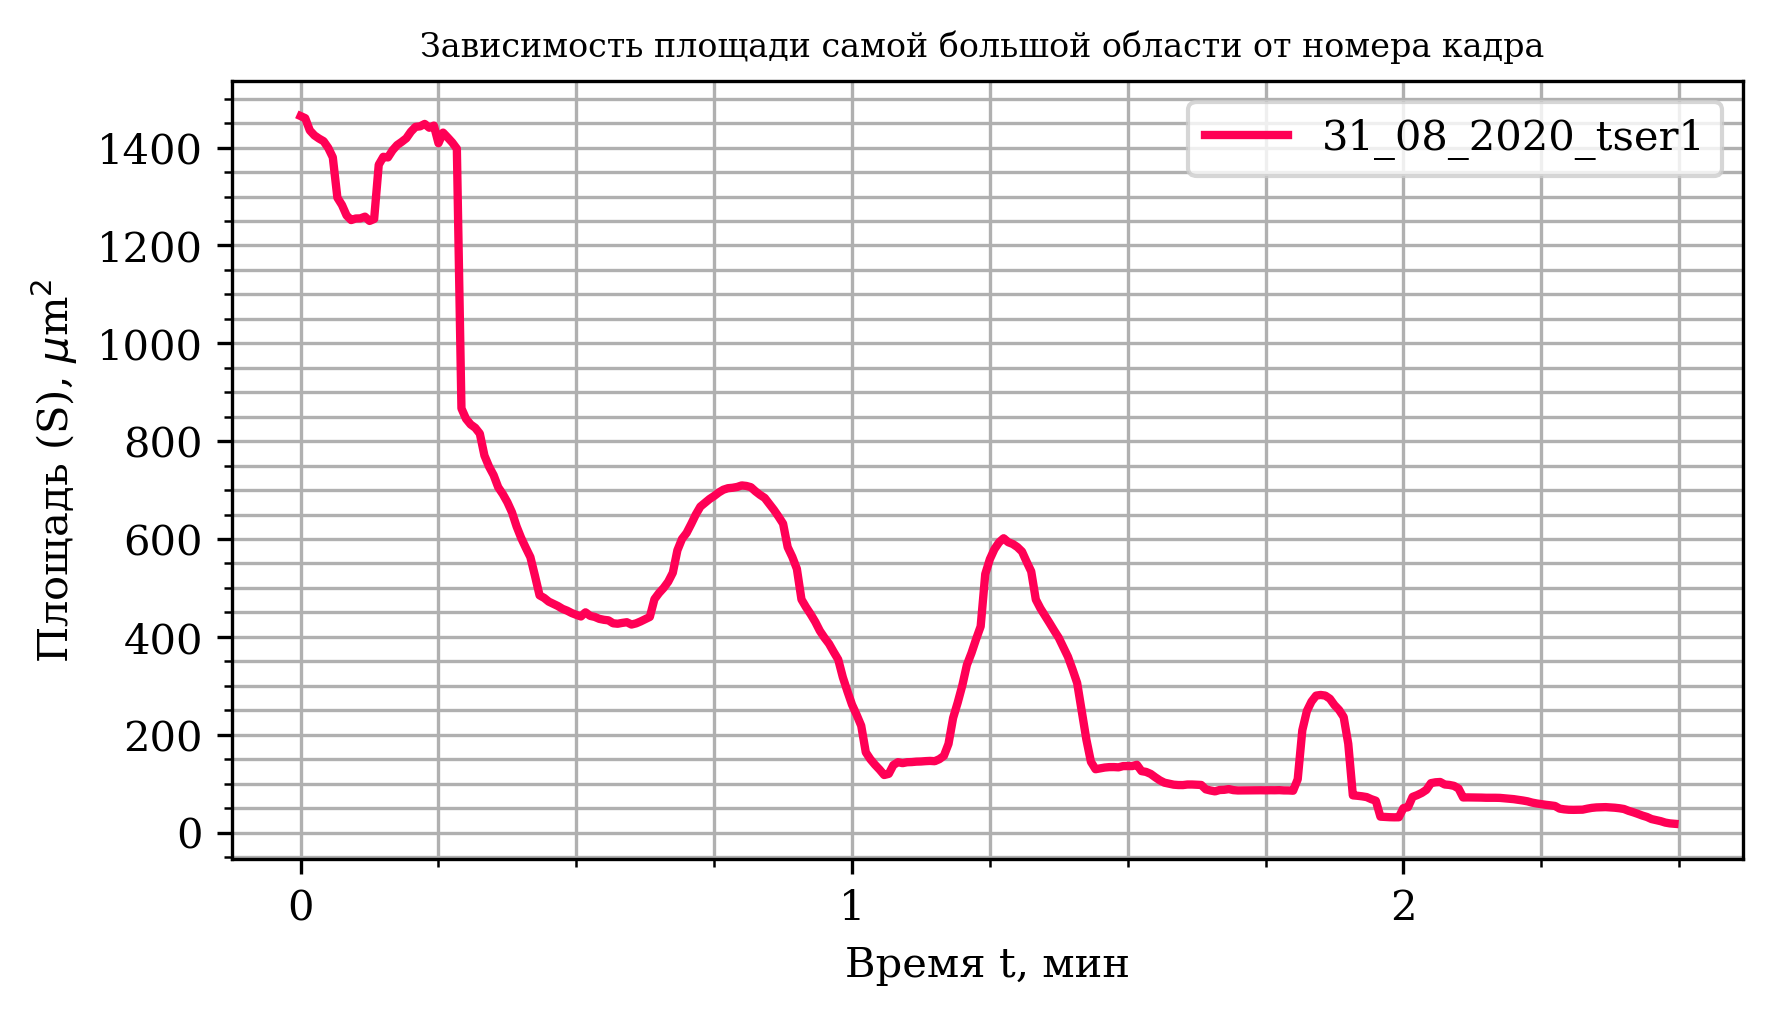

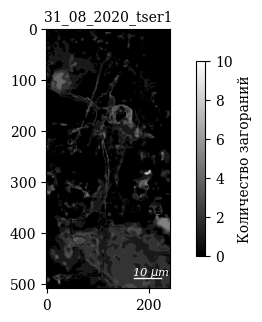

In [190]:
def start_analysis(file_paths, data_dir_save):
    squares_max = count_max_square(file_paths)
    title = count_hist(file_paths)[1]
    save_table(squares_max, file_paths, data_dir_save)
    PLOT = plot_square_to_time(squares_max, title = count_hist(file_paths)[1])
    array_for_hist = count_hist(file_paths)[0]
    hist = D2_histogfamm(array_for_hist, title)
    save_hist(hist, file_paths, data_dir_save)
    save_plt(PLOT, file_paths, data_dir_save)
start_analysis(file_paths, data_dir_save=r'C:/Users/sibir/Desktop/results')

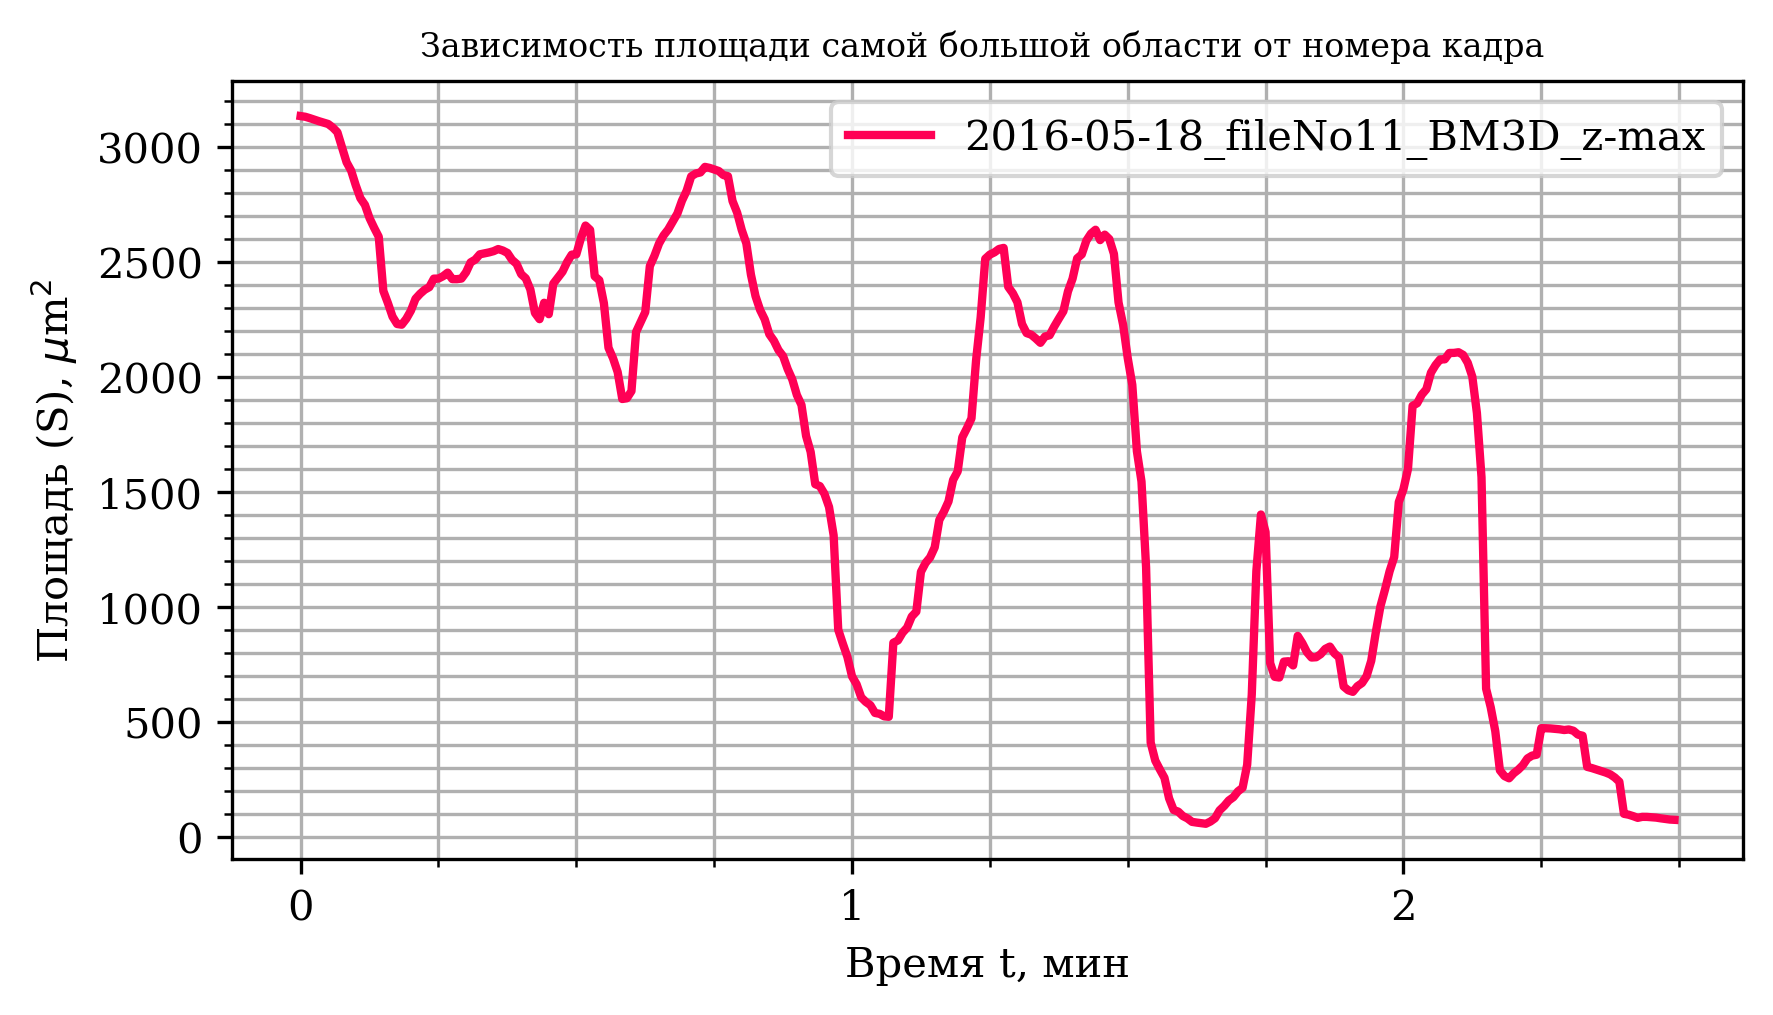

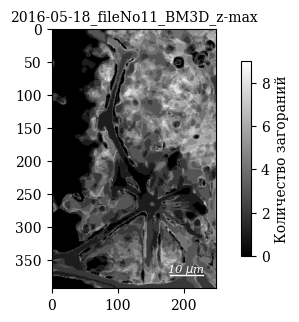

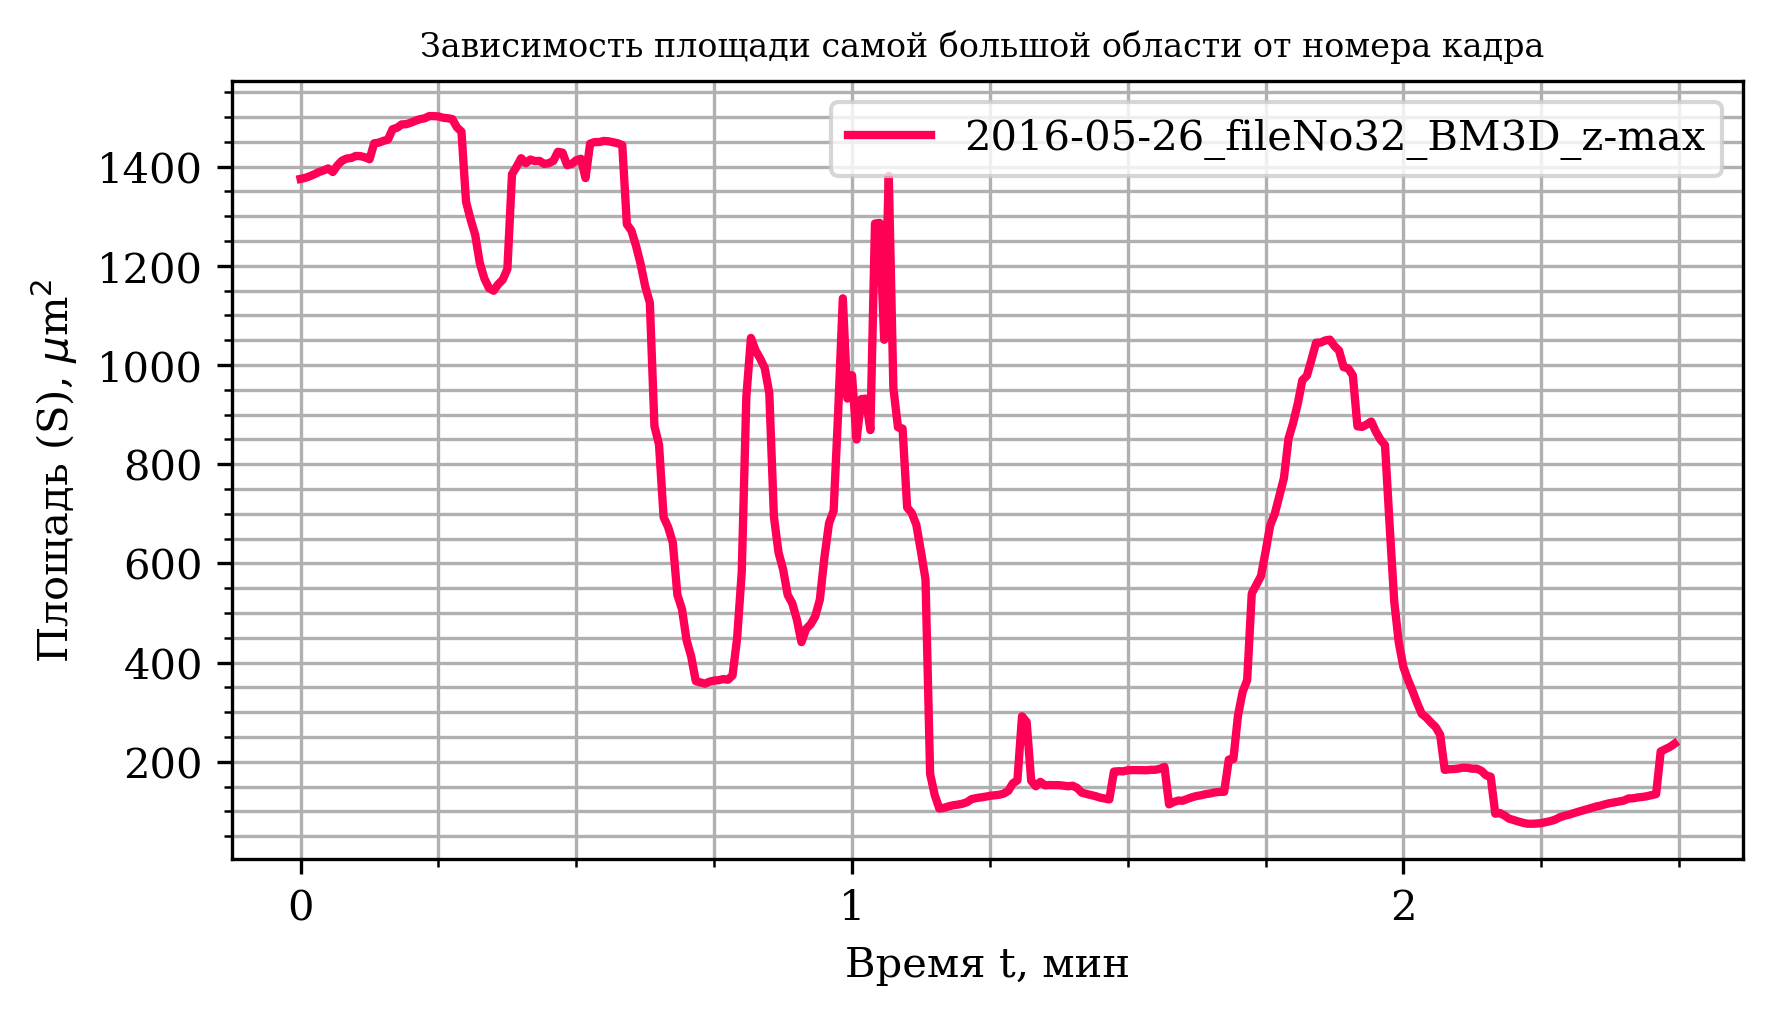

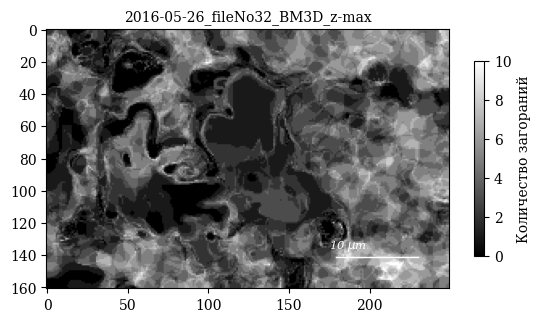

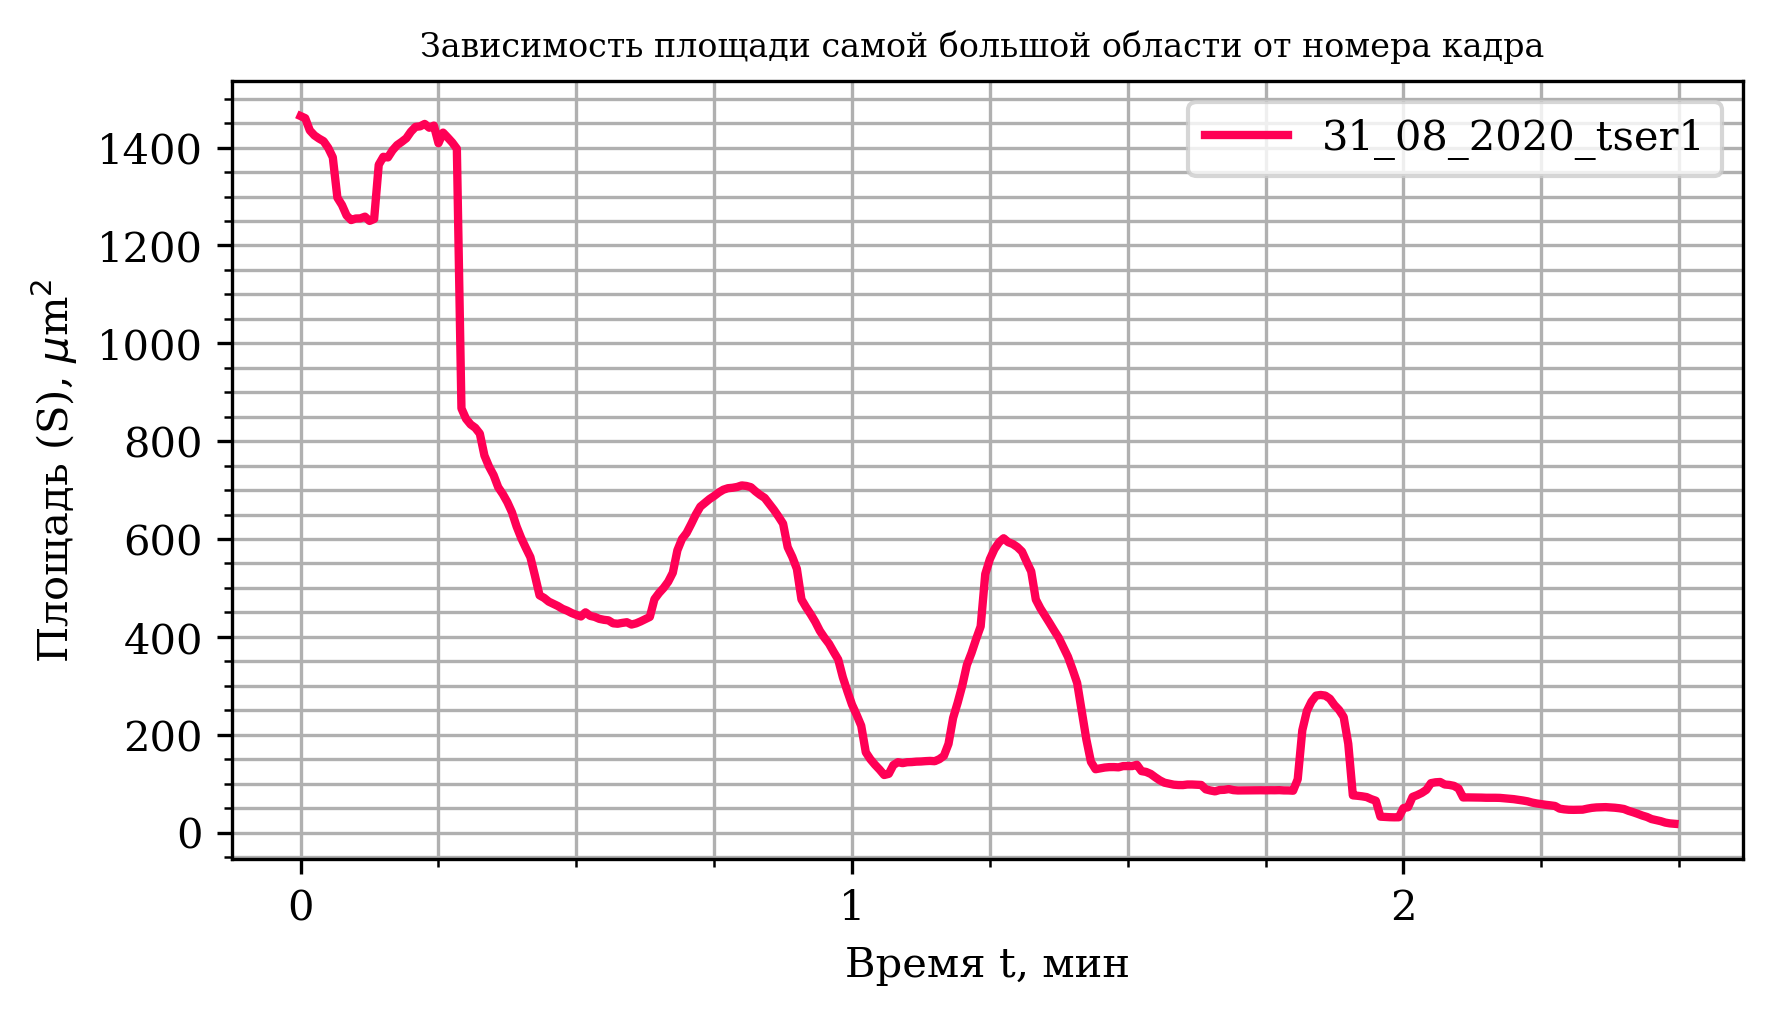

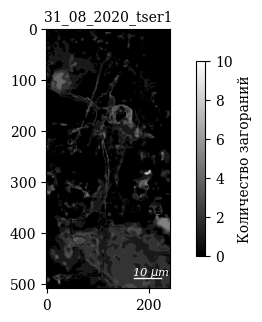

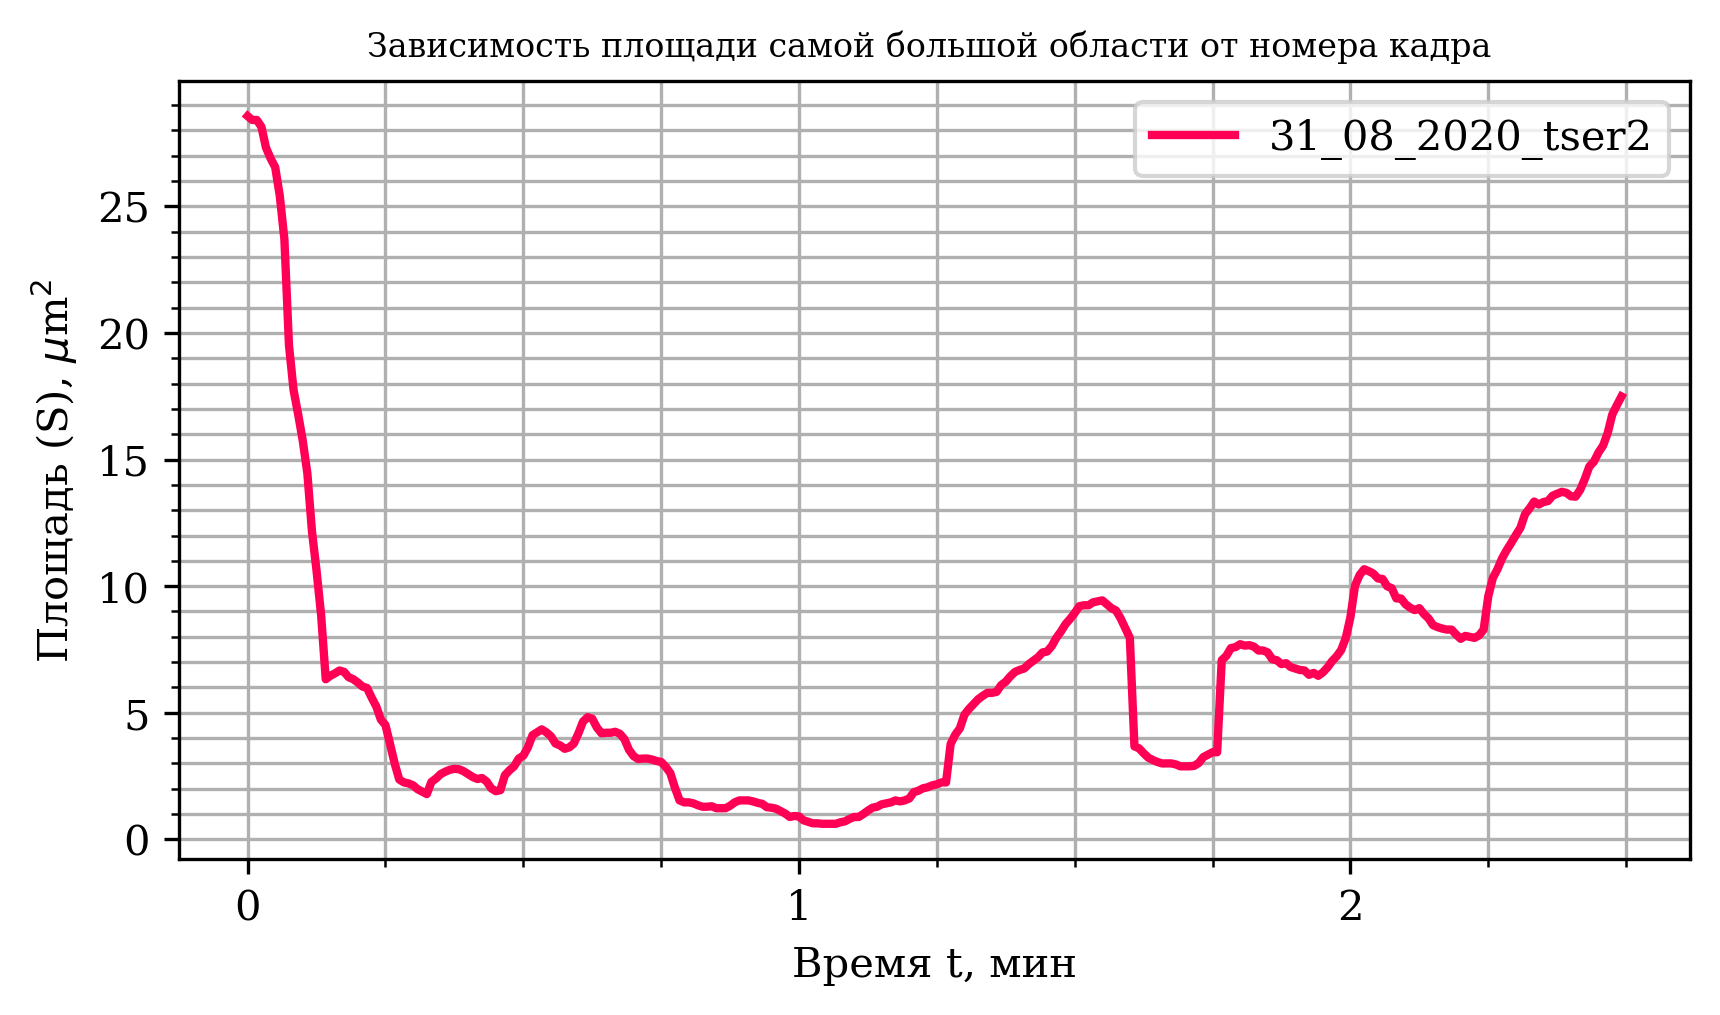

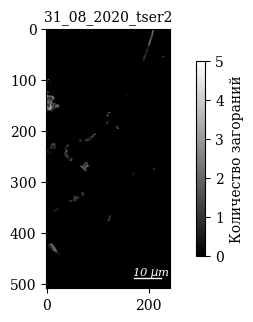

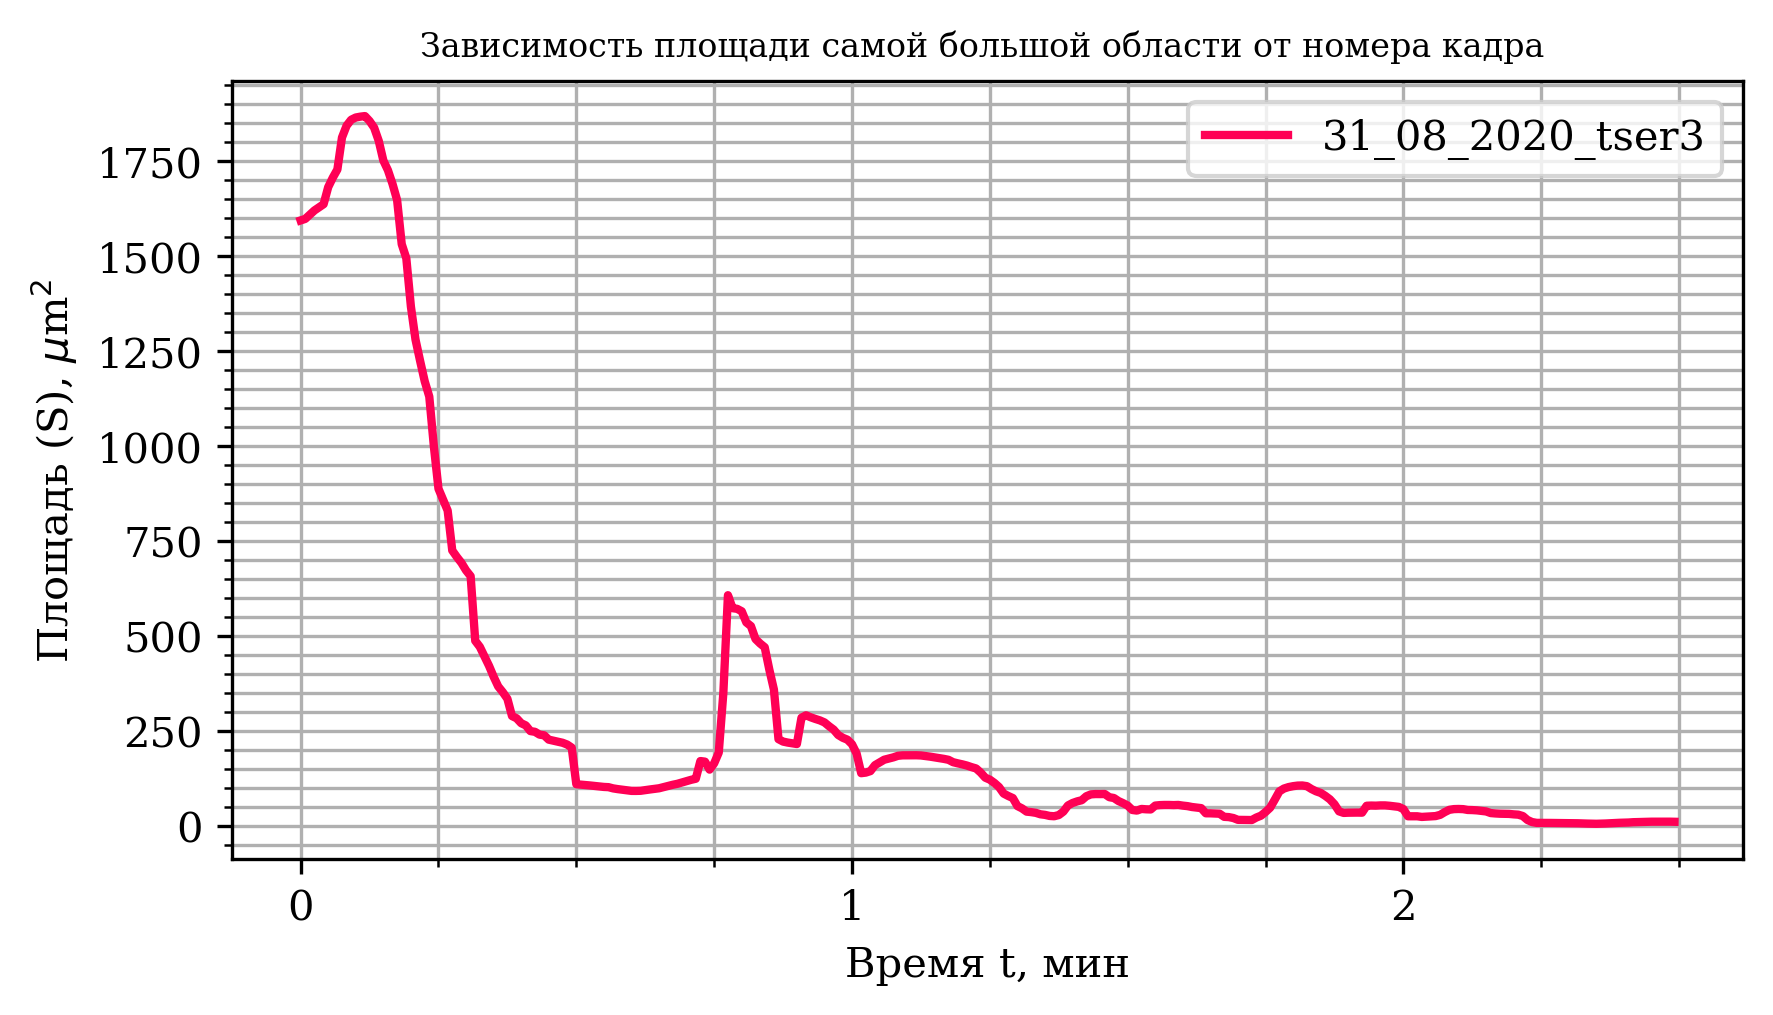

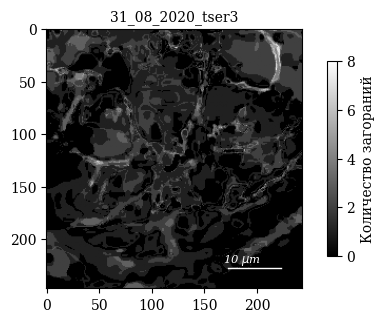

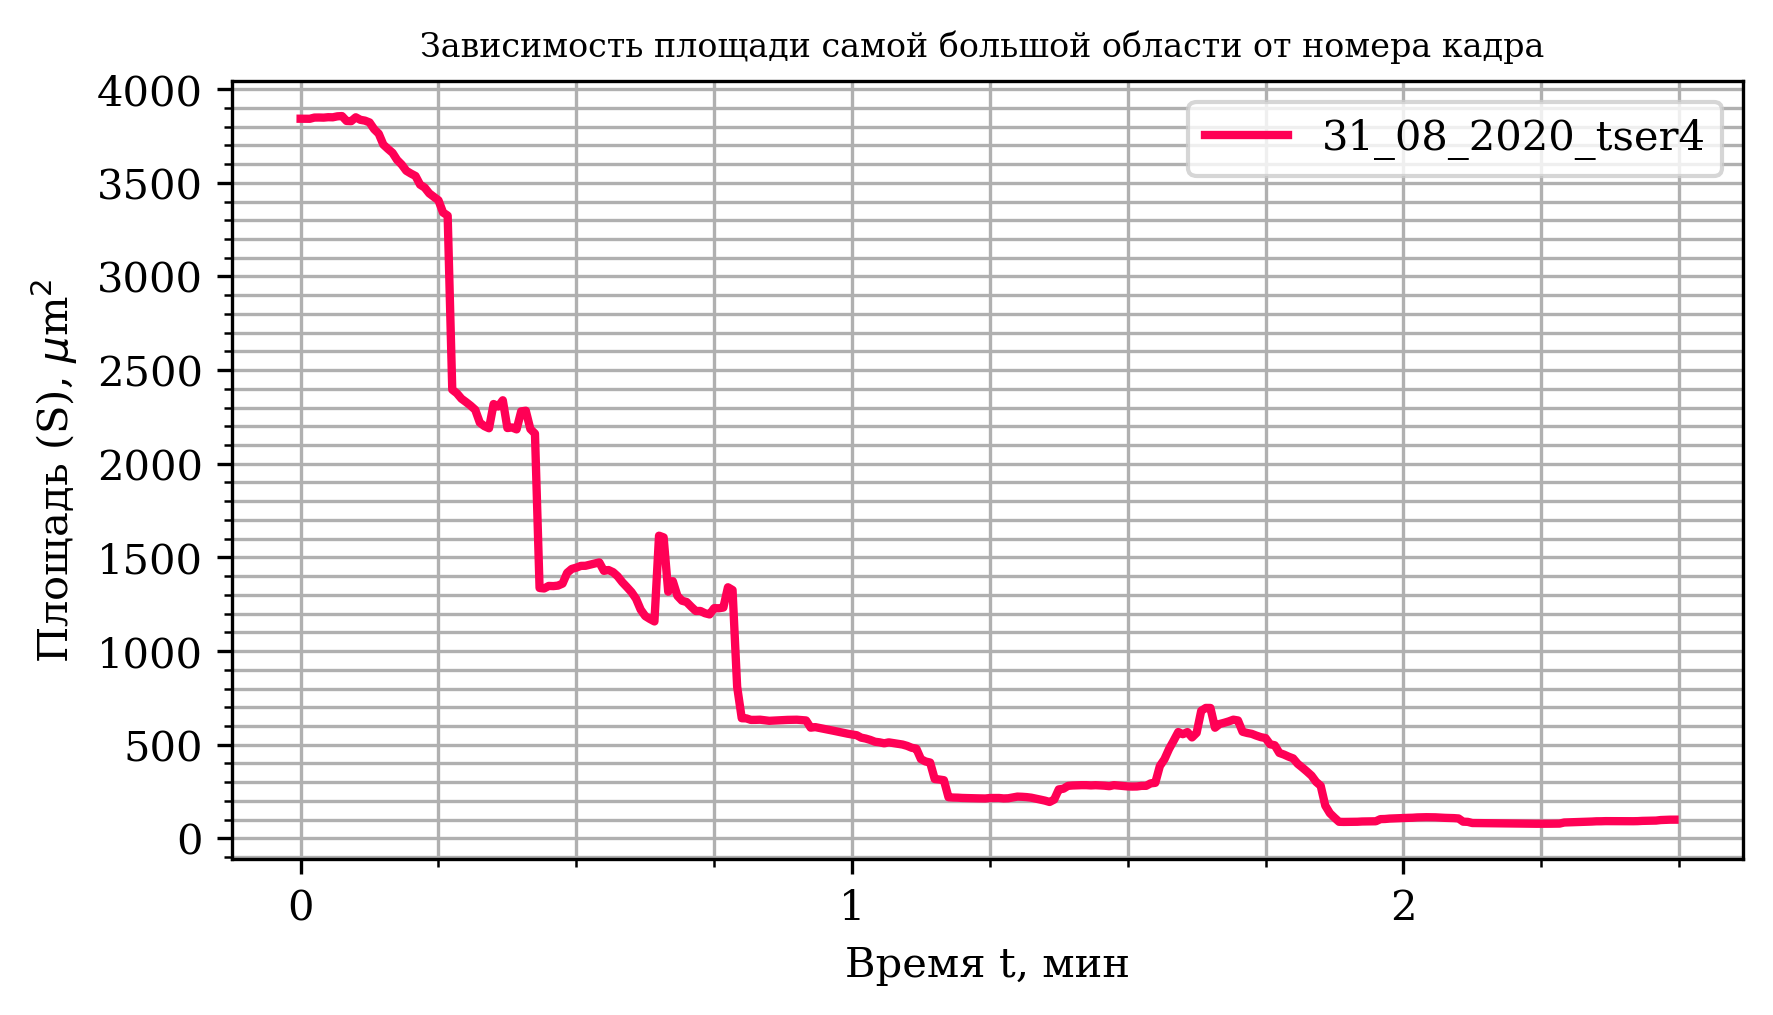

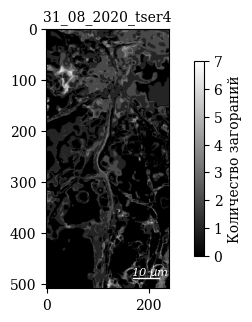

In [191]:
def analizes_full(mask, dir_folders, data_dir_save):
    list_of_all_paths = glob(str(mask))
    list_of_all_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    mask_for_folders = Path(dir_folders)/'**'
    folders = glob(str(mask_for_folders))
    file_paths = list(filter(lambda x: folders[1] in x, list_of_all_paths))
    for i in range(len(folders)):
        file_paths = list(filter(lambda x: folders[i] in x, list_of_all_paths)) 
        start_analysis(file_paths, data_dir_save)
mask = Path(r'C:/nn/Task_Astrocytes/Task_Astrocytes')/'**'/'**'/'events'/'**.png'
dir_folders = r'C:/nn/Task_Astrocytes/Task_Astrocytes'
data_dir_for_save = r'C:/Users/sibir/Desktop/results'
analizes_full(mask, dir_folders, data_dir_for_save)

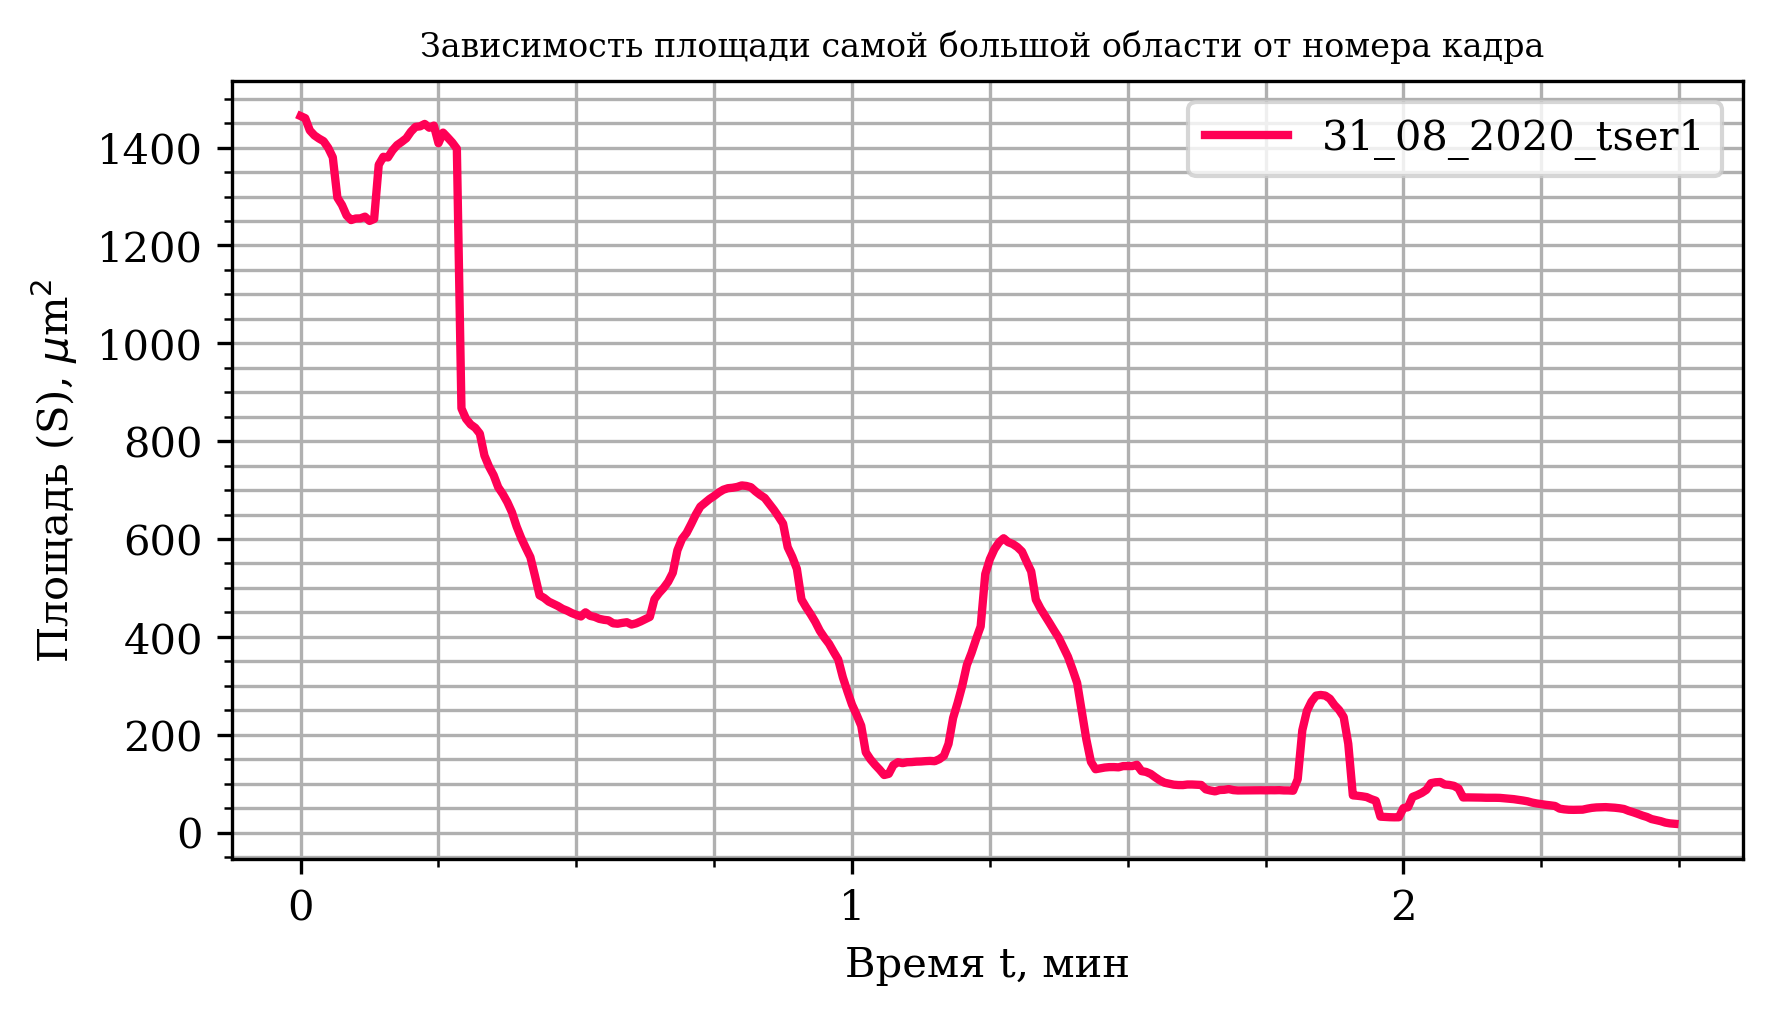

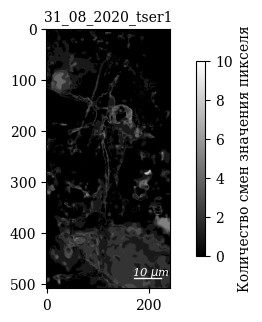

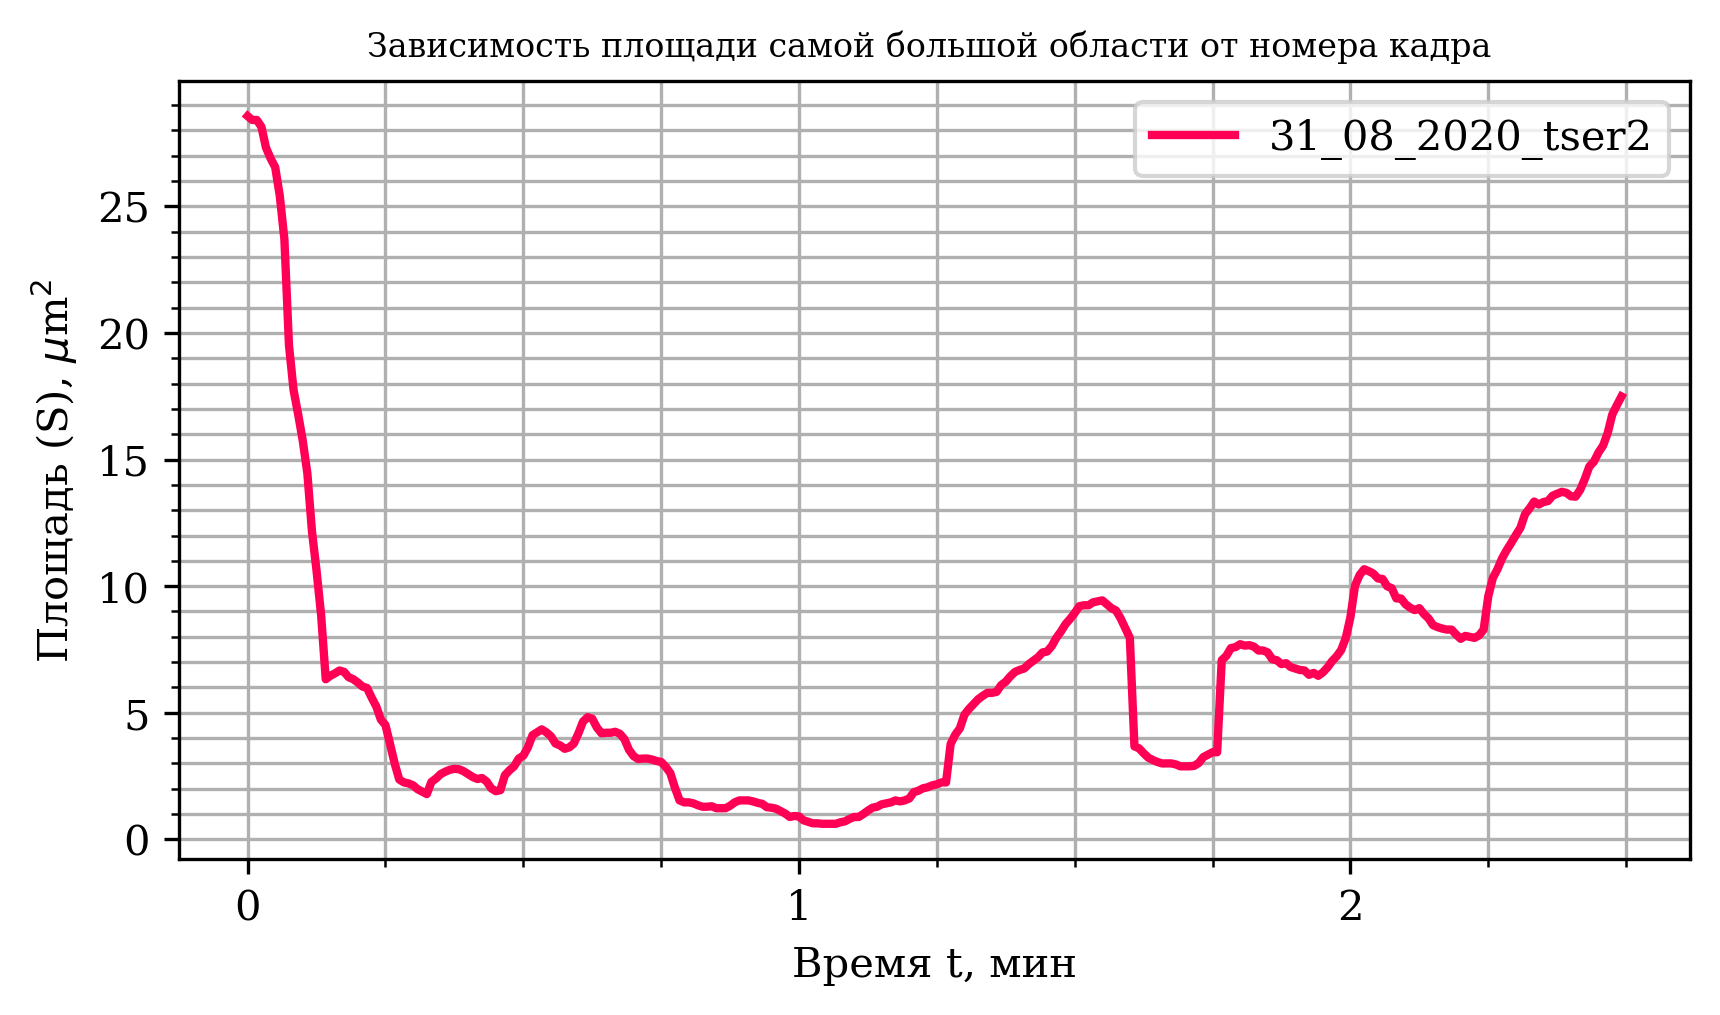

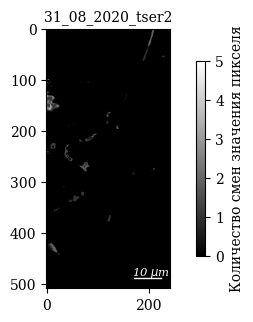

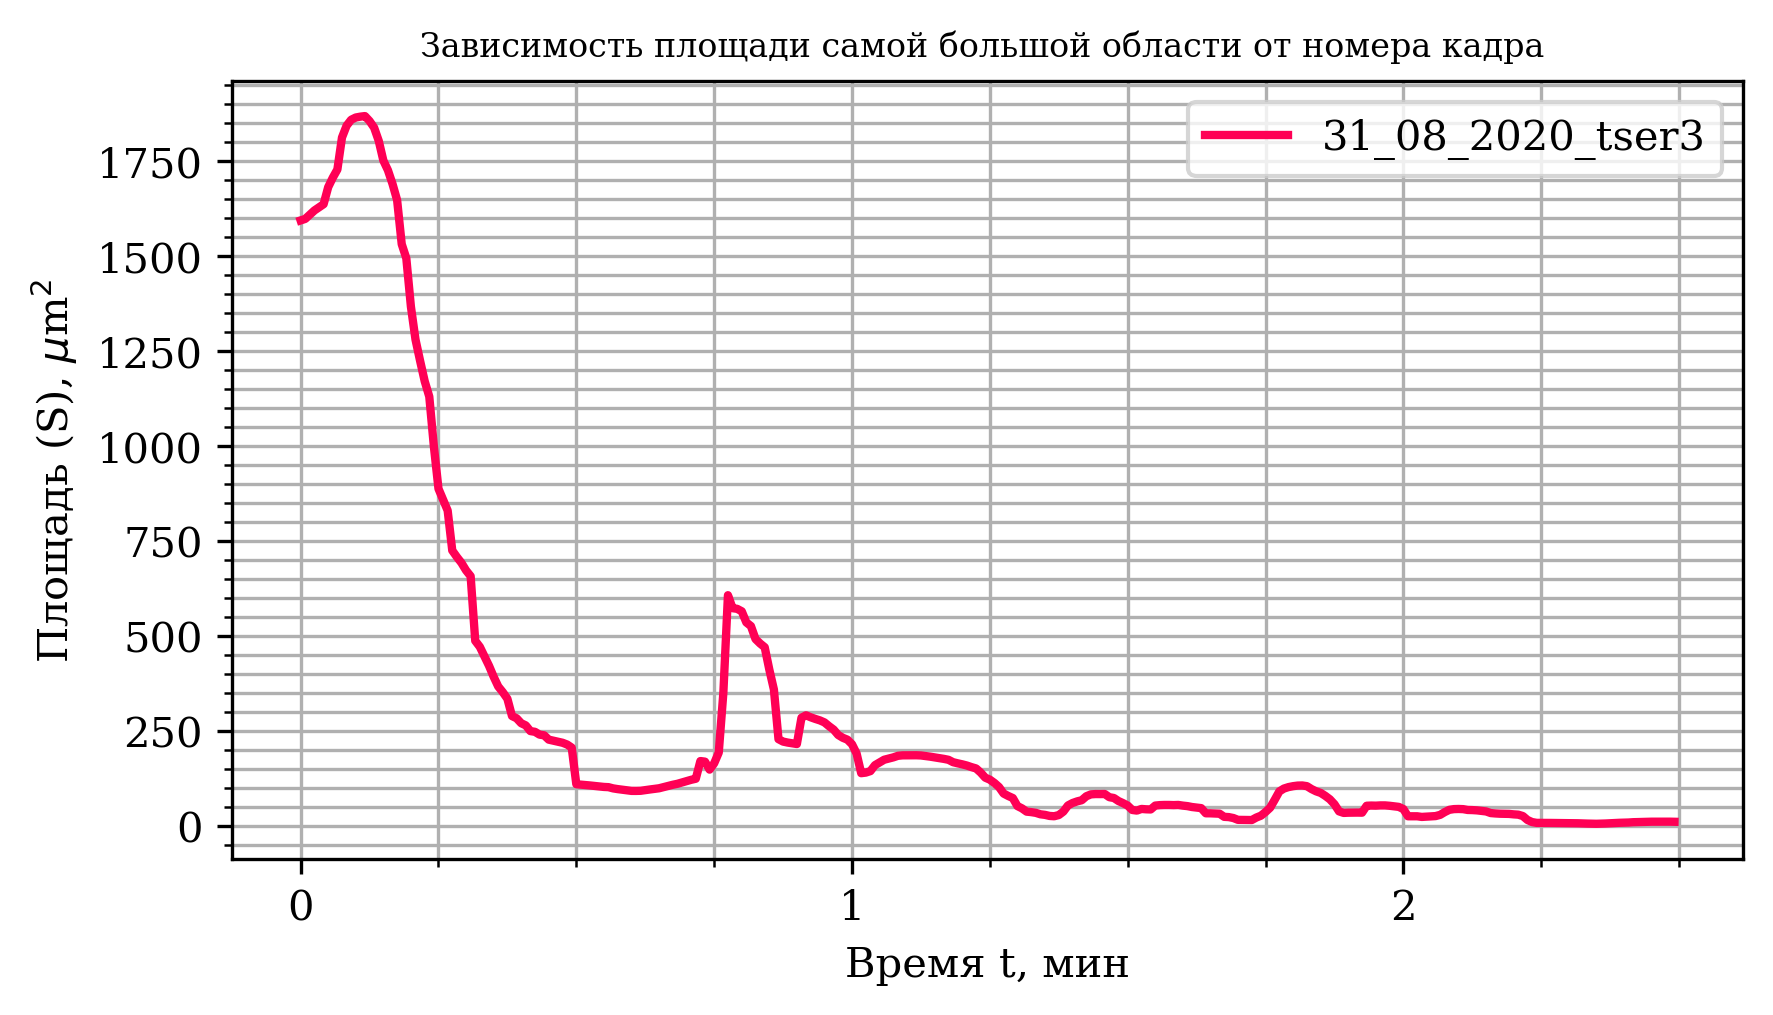

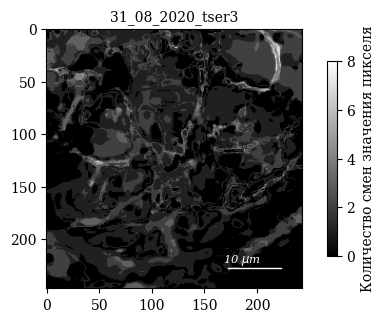

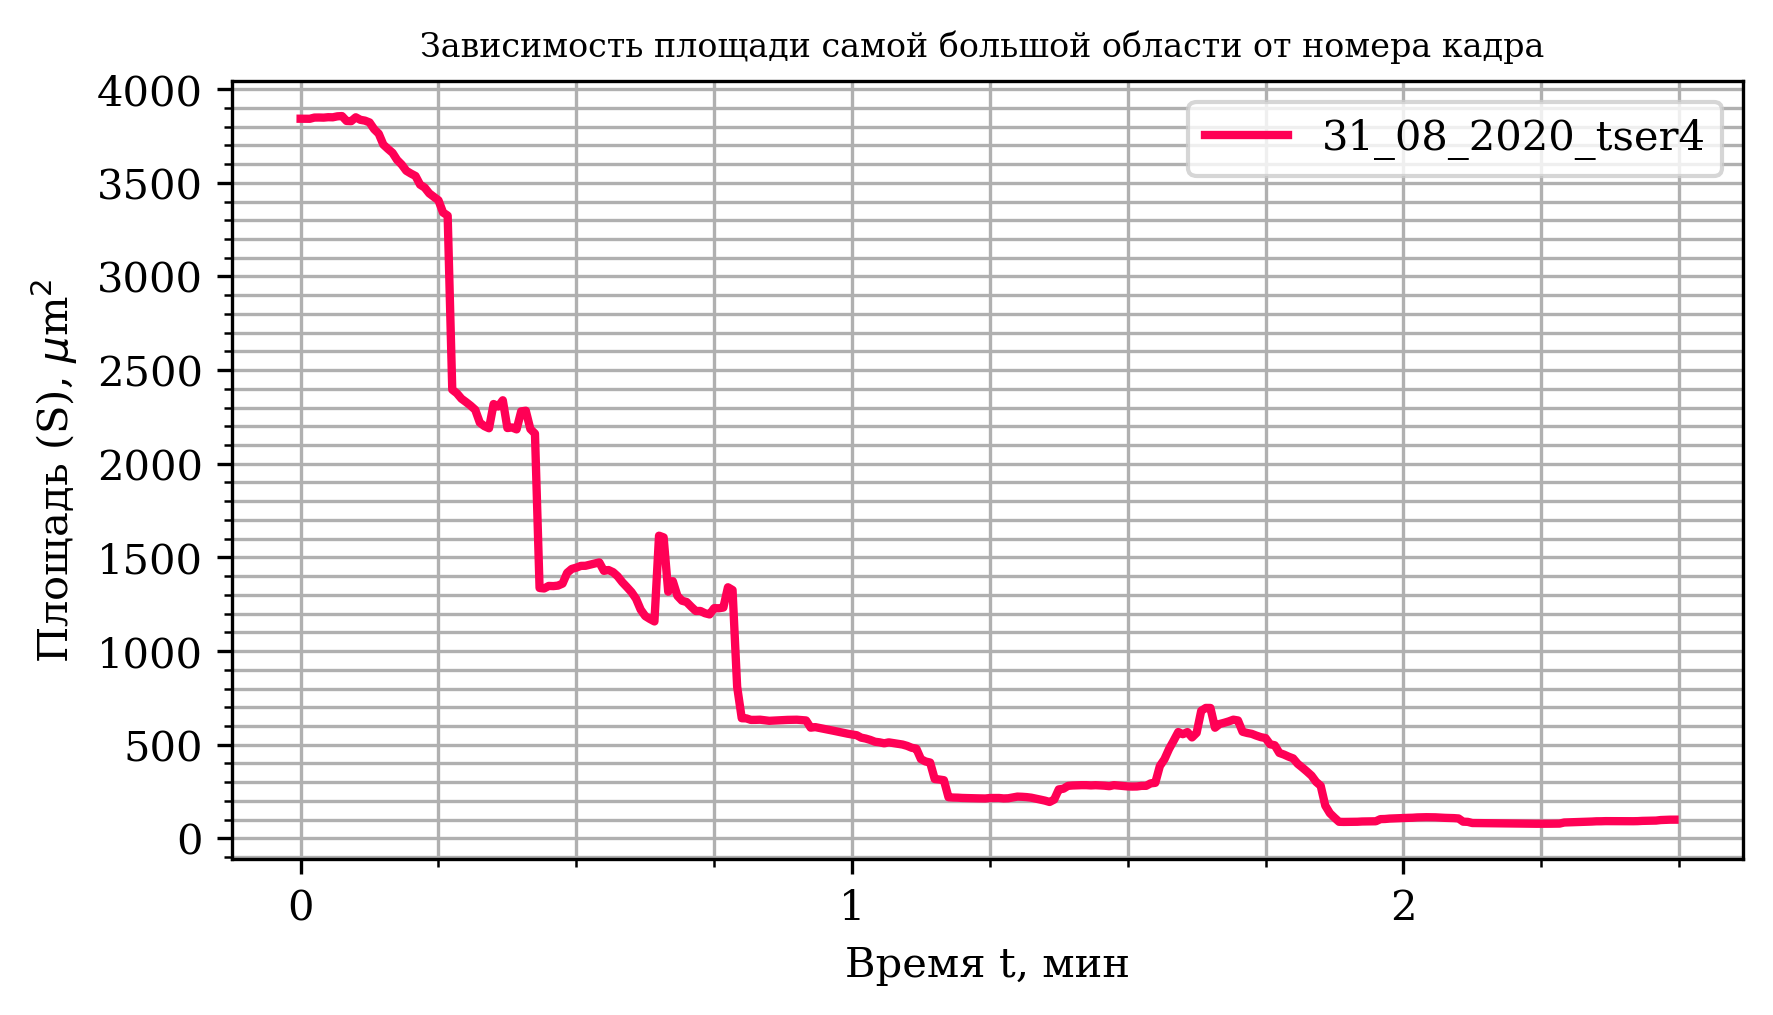

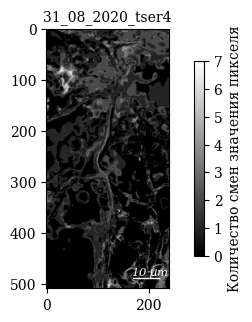

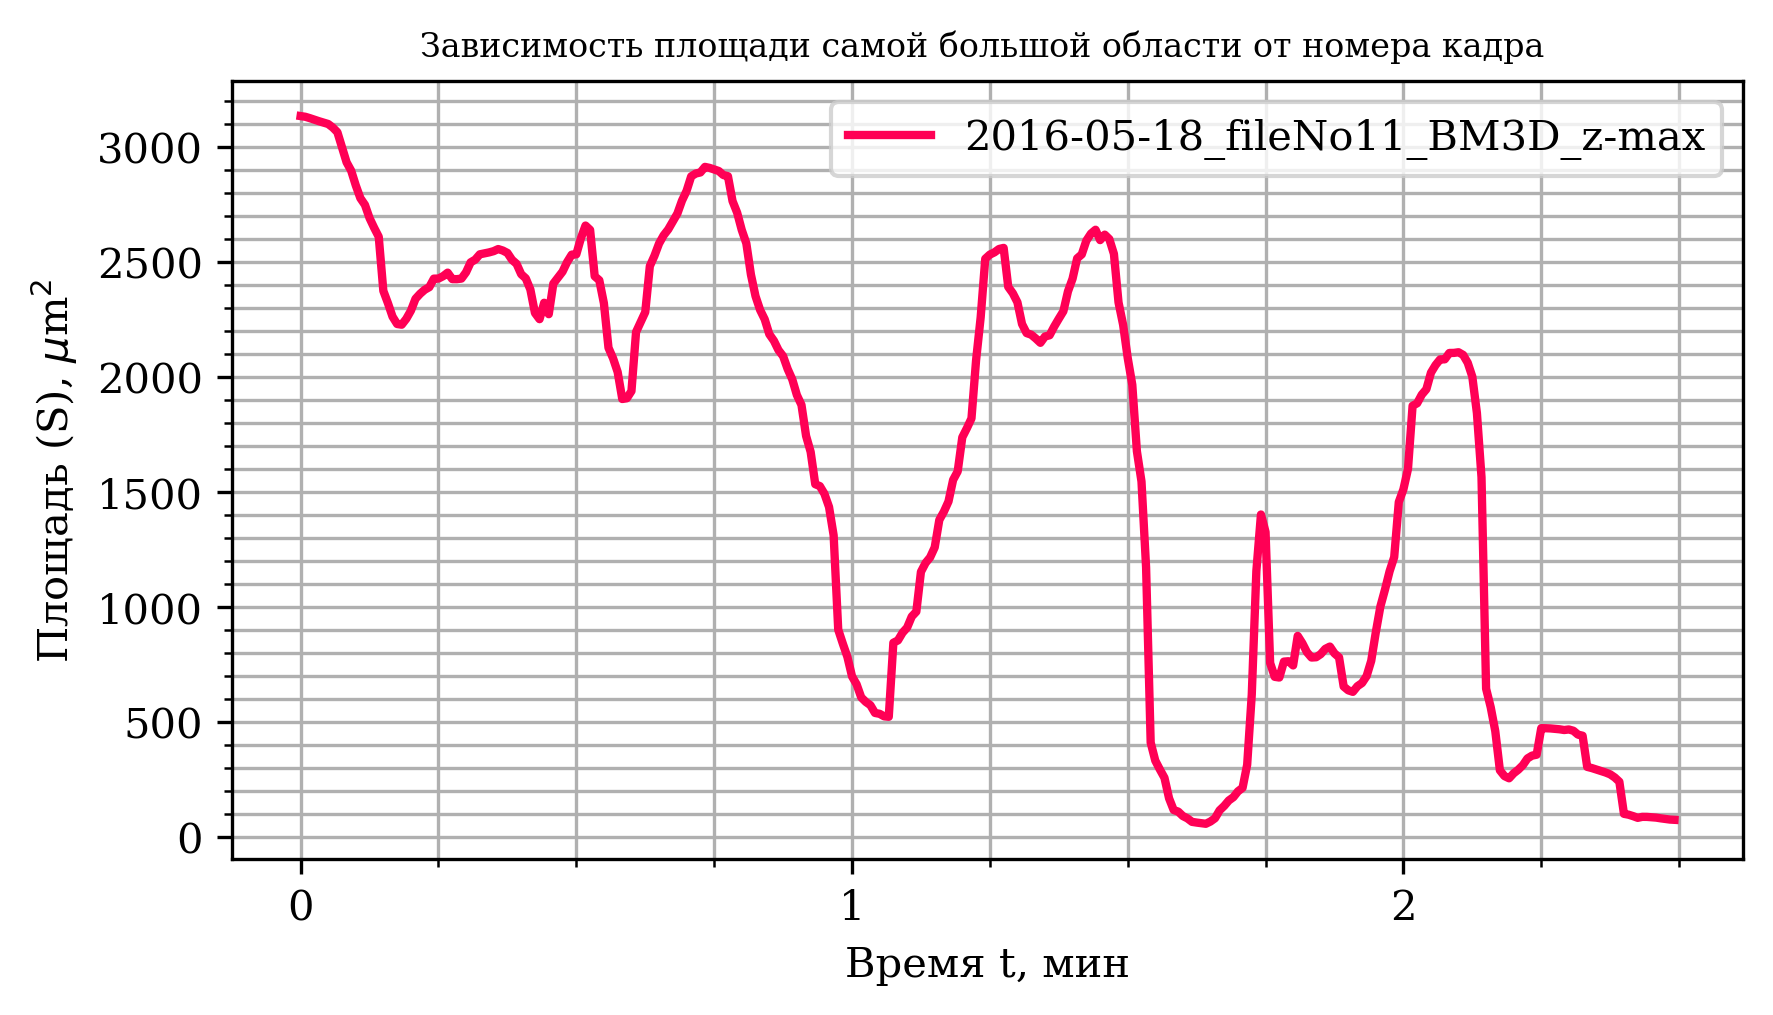

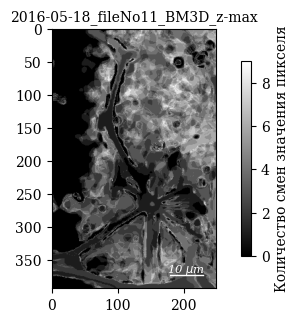

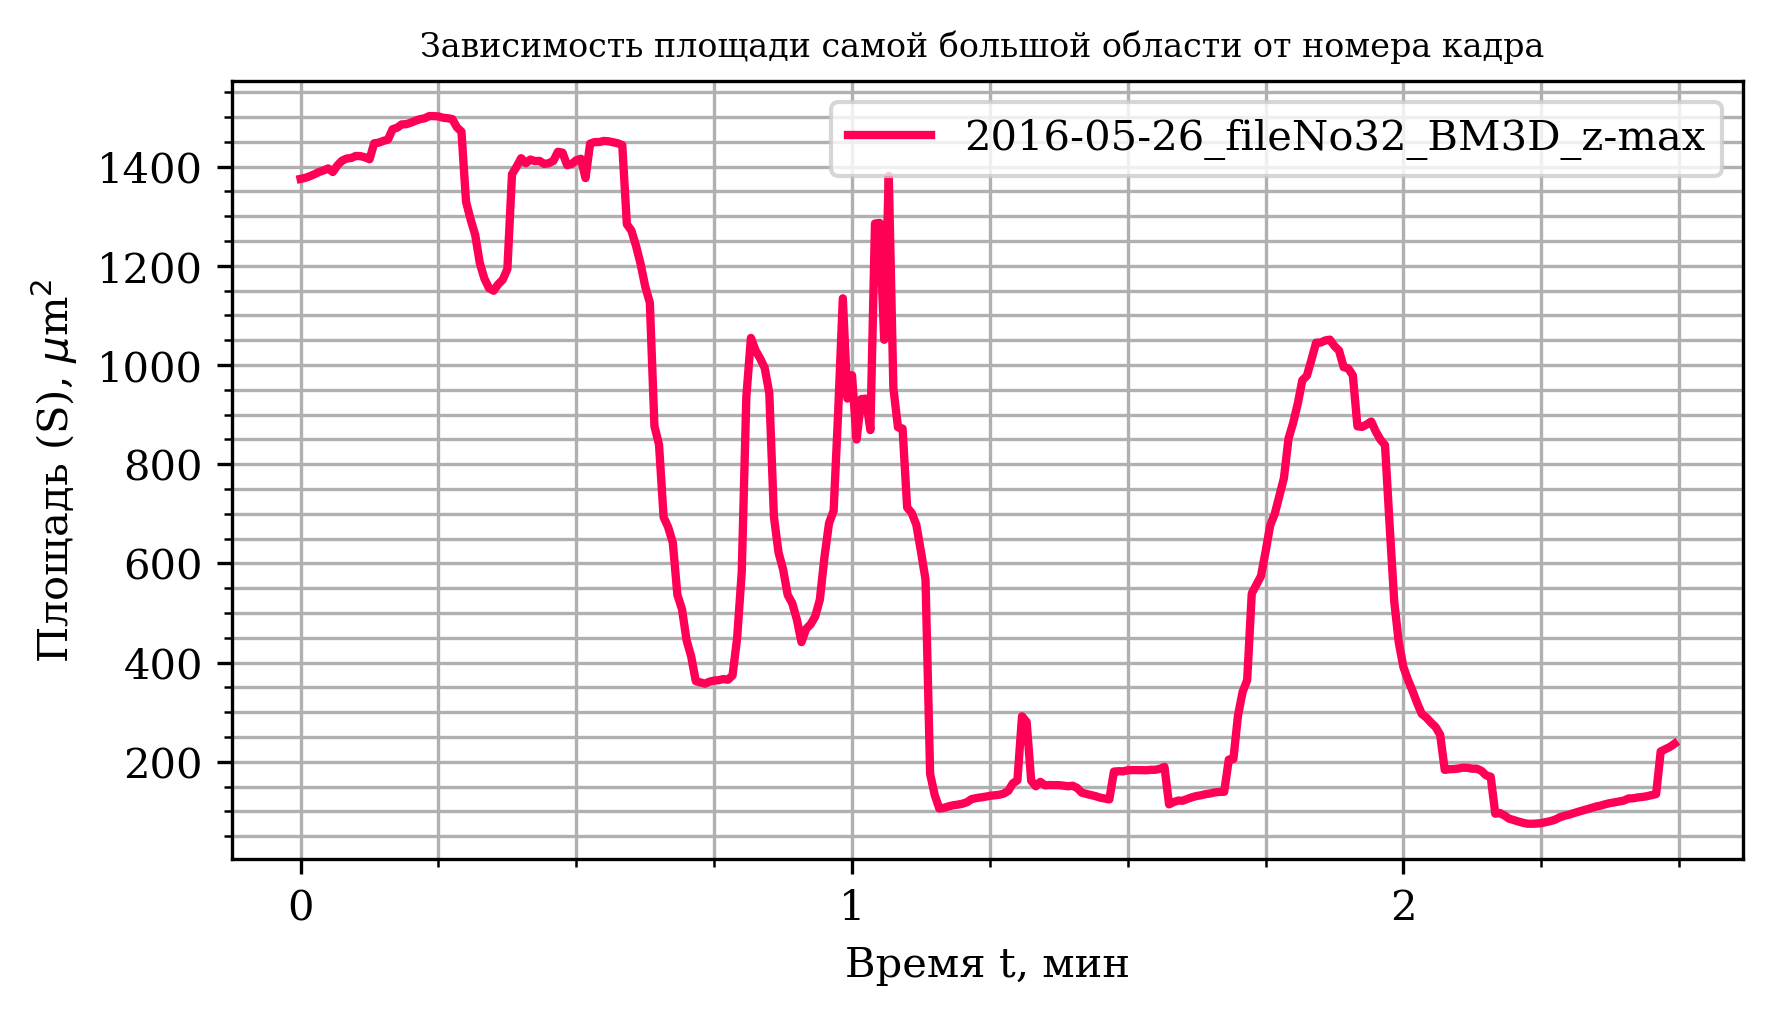

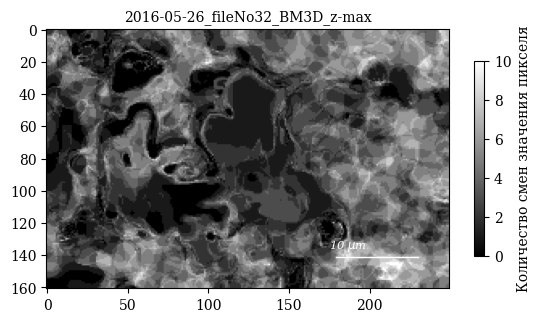

In [50]:
def function_to_func8(df_ev, data_dir):
    result = type_videorecords(df_ev)
    for i in range(len(result)):
        file_pathes = result[i]['file_path'].values
        func8(file_pathes, data_dir)
function_to_func8(df_ev = df_all[df_all.file_path.str.contains('event')], data_dir = r'C:/Users/sibir/Desktop/results')  

In [21]:
import astro_pack

In [22]:
from astro_pack import all_images, convert_to_list, count_for_hist, D2_hist

In [23]:
from astro_pack.all_images import read_data
help(read_data)

Help on function read_data in module astro_pack.all_images:

read_data(mask)
    type(mask) - pathlib2.WindowsPath
    Функция read_data принимает на вход пути к файлам.
    Возвращает dataFrame, в столбце которого содержится информация о пути к изображениям. 
    Пример:
    mask = Path(r'C:/nn/Task_Astrocytes/Task_Astrocytes') / '**'/ '**' / '**'/ '***.png')
    all_images.read_data(mask)



In [24]:
df_all = all_images.read_data(mask = Path(r'C:/nn/Task_Astrocytes/Task_Astrocytes') / '**'/ '**' / 'events'/ '***.png')

In [25]:
file_paths = convert_to_list.select_rows_by_value(df_all, value_for_select='tser1')

In [26]:
from astro_pack.convert_to_list import select_rows_by_value
help(select_rows_by_value)

Help on function select_rows_by_value in module astro_pack.convert_to_list:

select_rows_by_value(df_all, value_for_select)
    Принимает на вход:
    
    - df_all (pandas.core.frame.DataFrame) - дата фрейм с данными
    (в столбцах находятся пути к анализируемым изображениям);
    
    - value_for_select (str) - строковый объект, входящий в состав пути к изображениям
     и соответствующий определенной видеозаписи (названию папки).
    Нужен для отбора строк из df_all по значению.
    Ex.:
    from glob import glob
    from pathlib2 import Path
    mask = Path(r'C:/Task_Astrocytes') / '**'/ '**'/ '***.png'
    file_names = glob(str(mask))
    df_all = pd.DataFrame({'file_pathes' : file_names})
    xy_dataFrame.events1800(df_all, value_for_select = 'video_rec_1)
    
    Возвращает список путей к картинкам, находящимся в одной папке.



In [27]:
array_for_hist = count_for_hist.count_hist(file_paths)[0]
title = count_for_hist.count_hist(file_paths)[1]

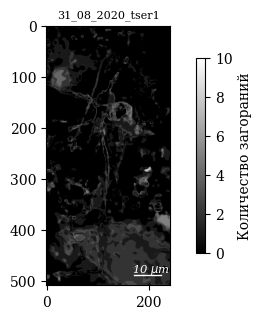

In [28]:
hist = D2_hist.D2_histogfamm(array_for_hist, title)

In [29]:
from astro_pack import square_of_max_area, plot_of_square_of_events
from astro_pack import save_histogramm, save_plot, table_save
from astro_pack import processing_single_record, full_processing

In [30]:
squares_max = square_of_max_area.count_max_square(file_paths)

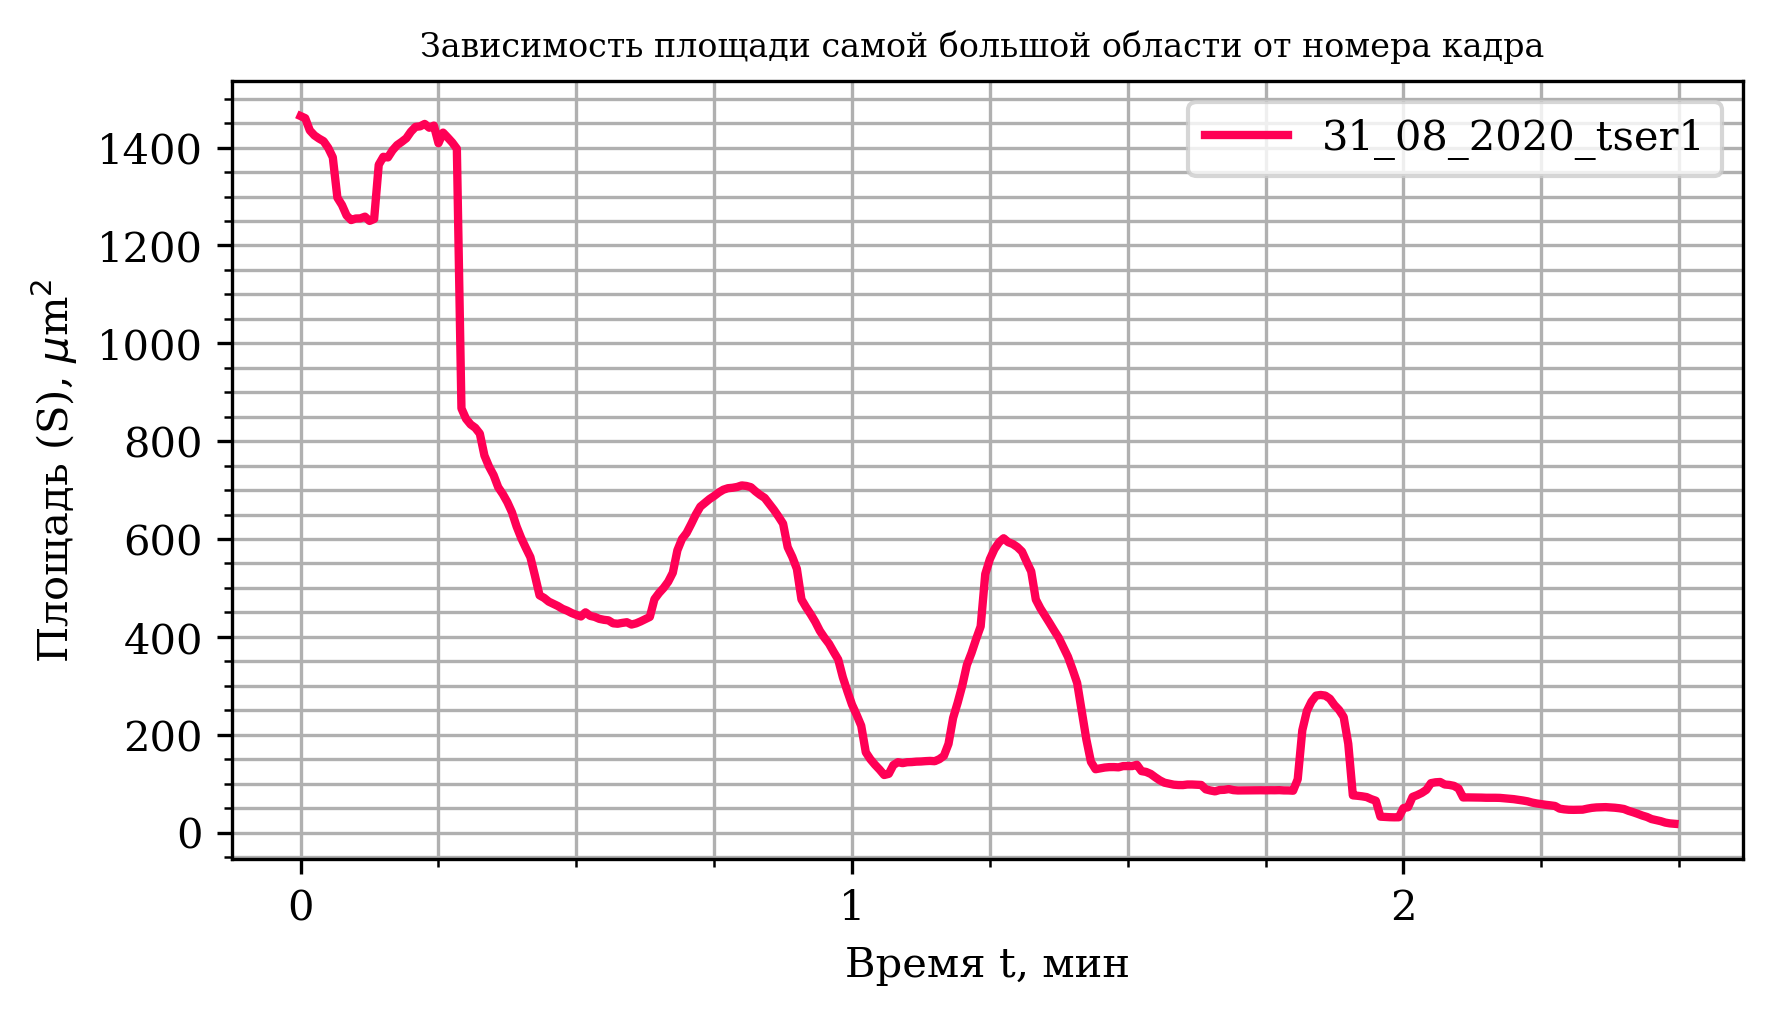

In [31]:
PLOT = plot_of_square_of_events.plot_square_to_time(squares_max, title)

In [38]:
save_plot.save_plt(PLOT, file_paths, data_dir_save = r'C:/Users/sibir/Desktop/results')

In [35]:
save_histogramm.save_hist(hist, file_paths, data_dir = r'C:/Users/sibir/Desktop/results')

In [36]:
table_save.save_table(squares_max, file_paths, data_dir_save = r'C:/Users/sibir/Desktop/results')

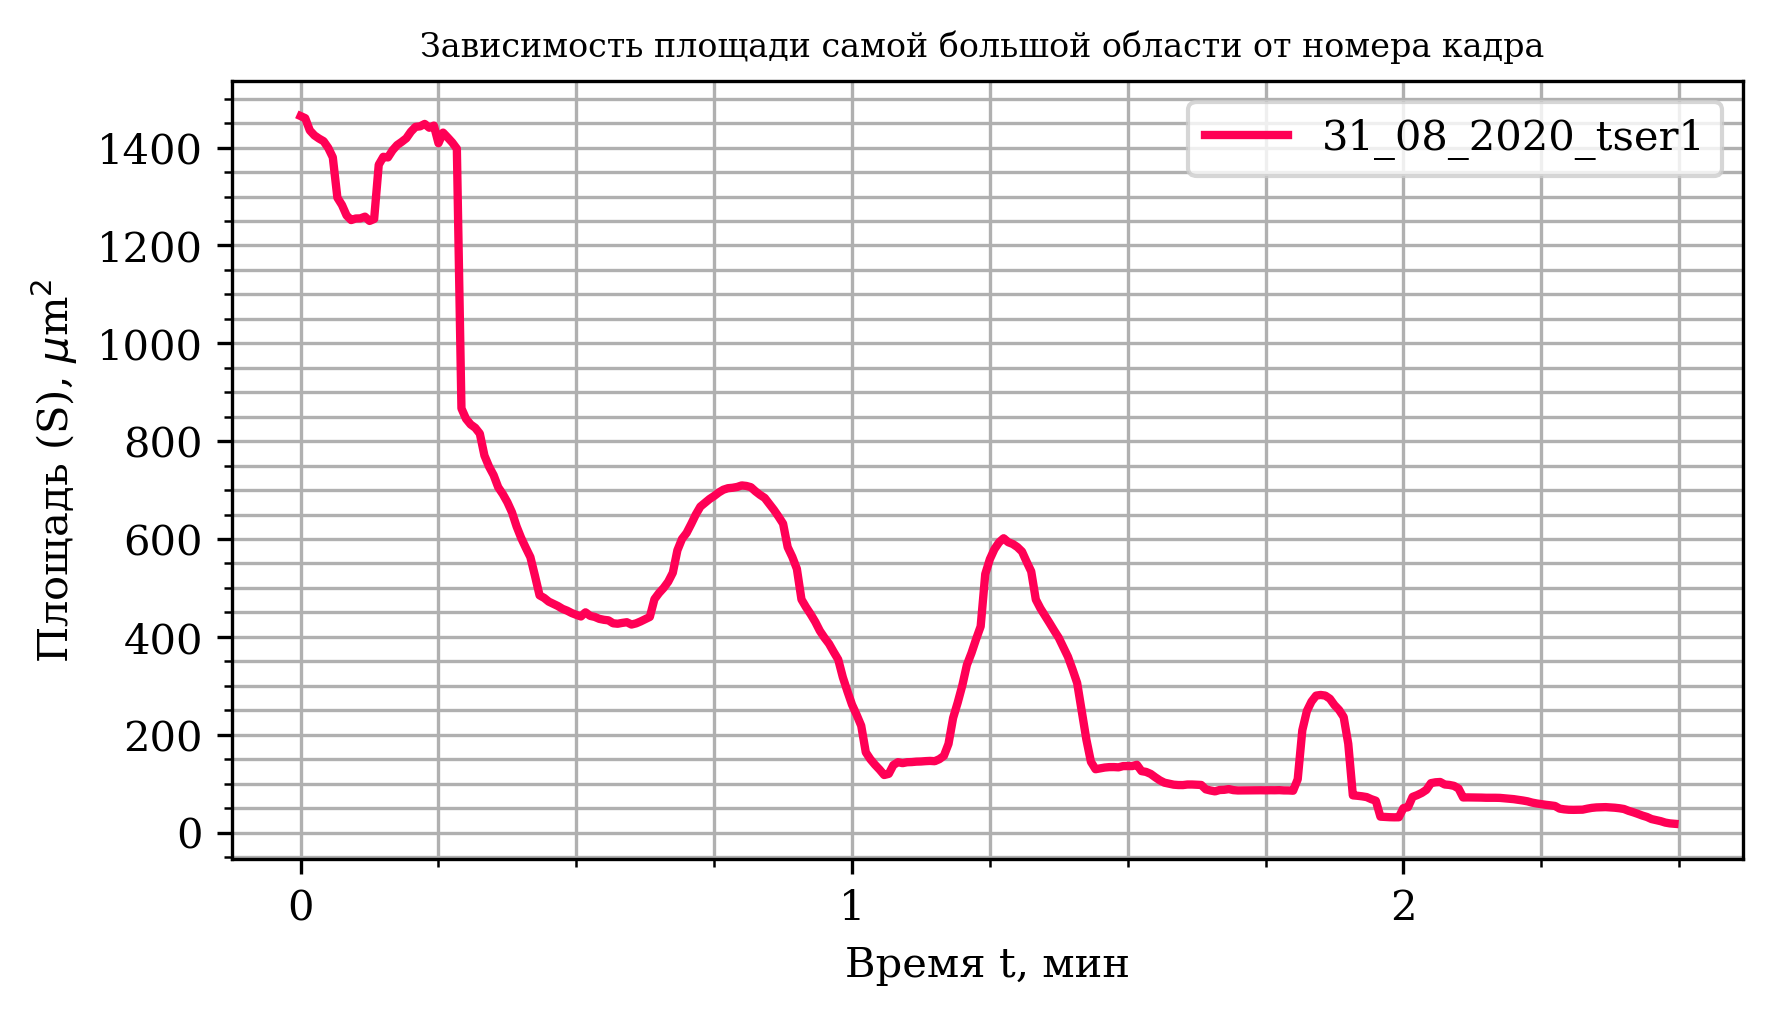

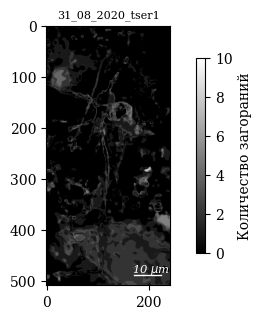

In [18]:
processing_single_record.start_analysis(file_paths, data_dir_save = r'C:/Users/sibir/Desktop/results')

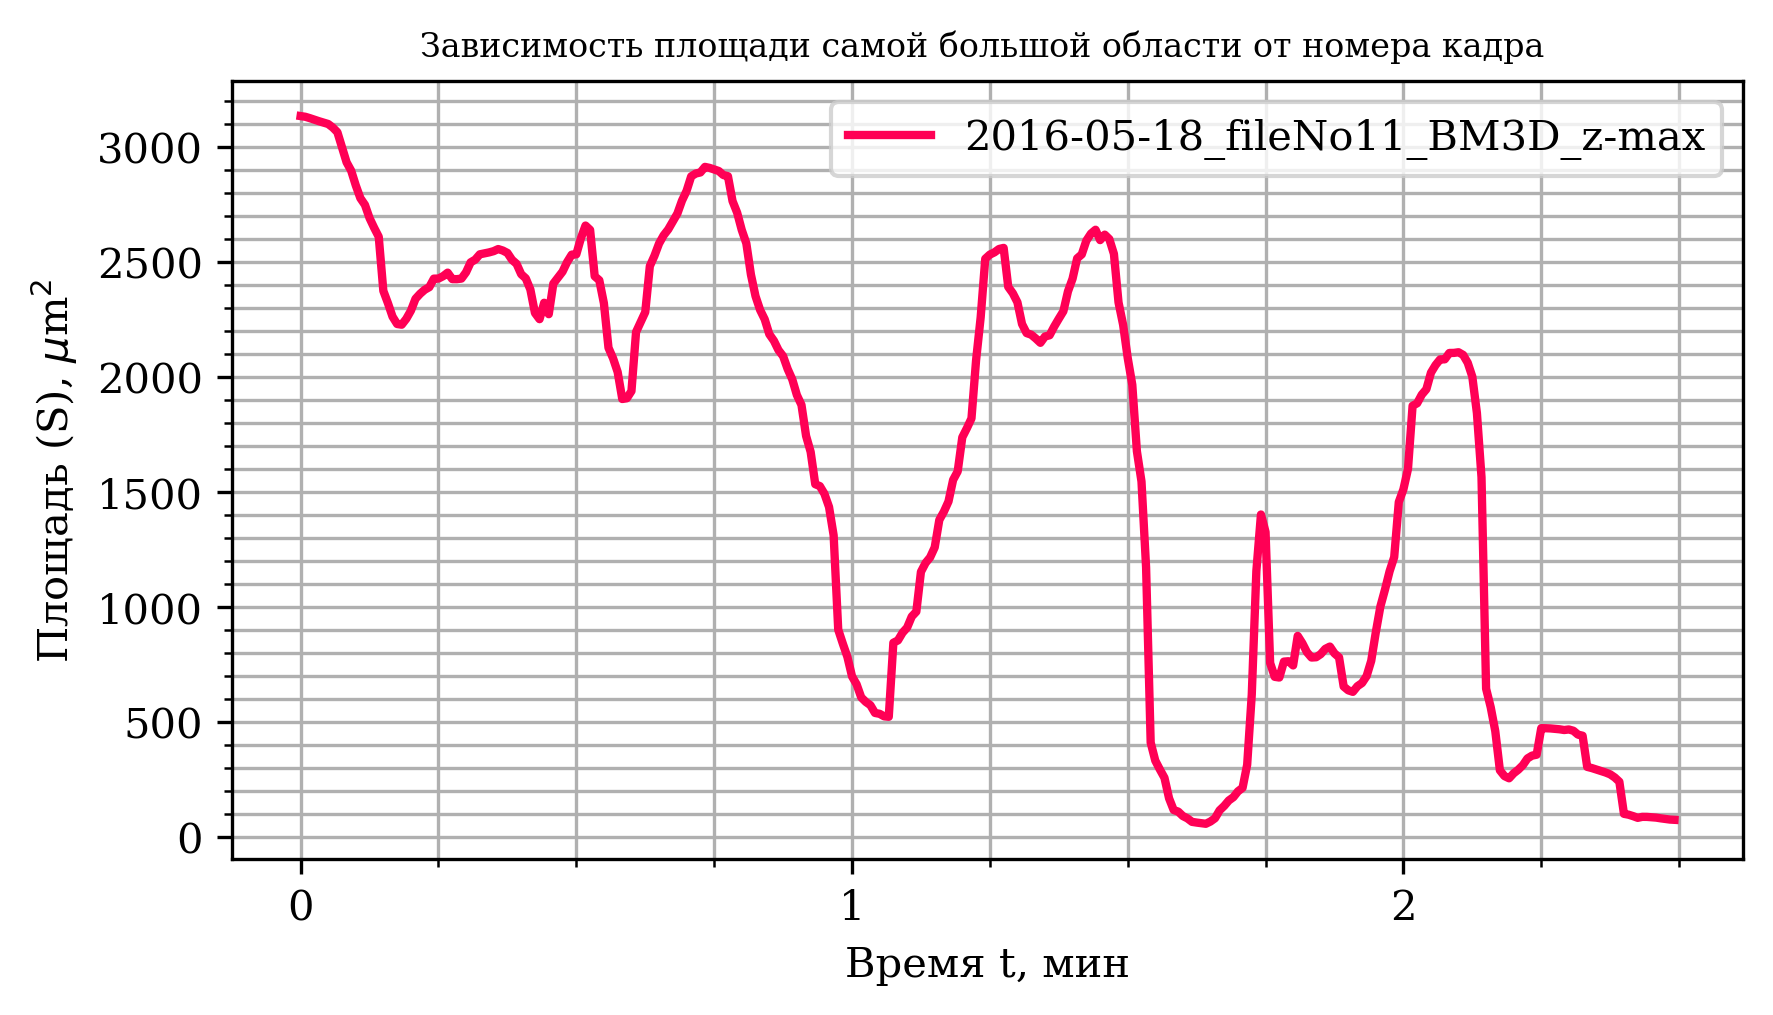

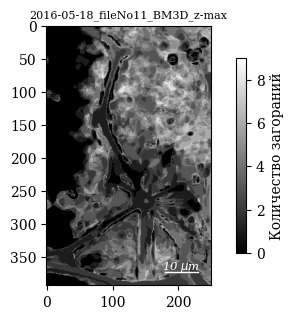

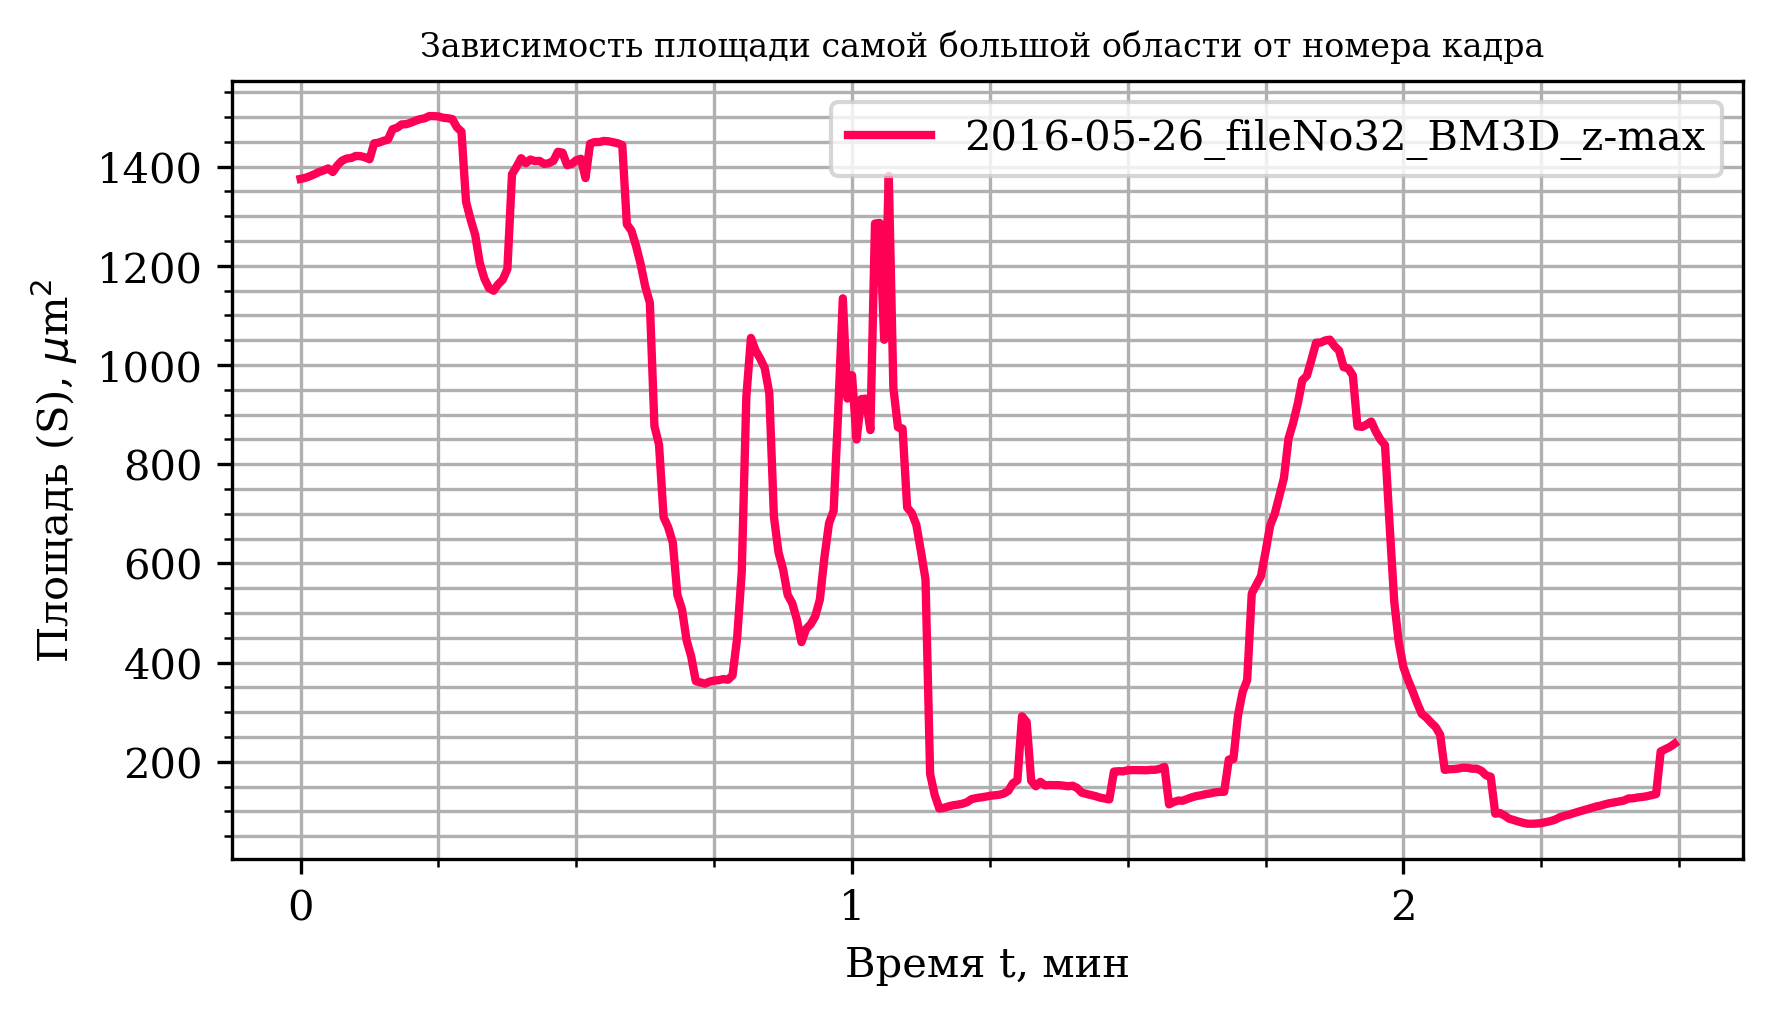

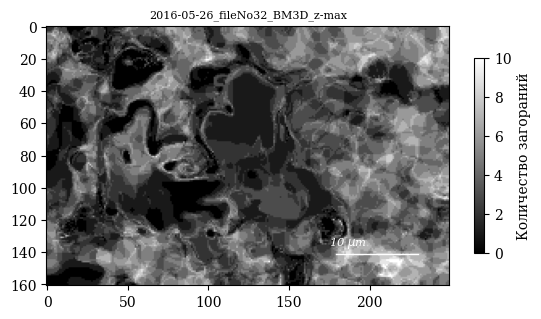

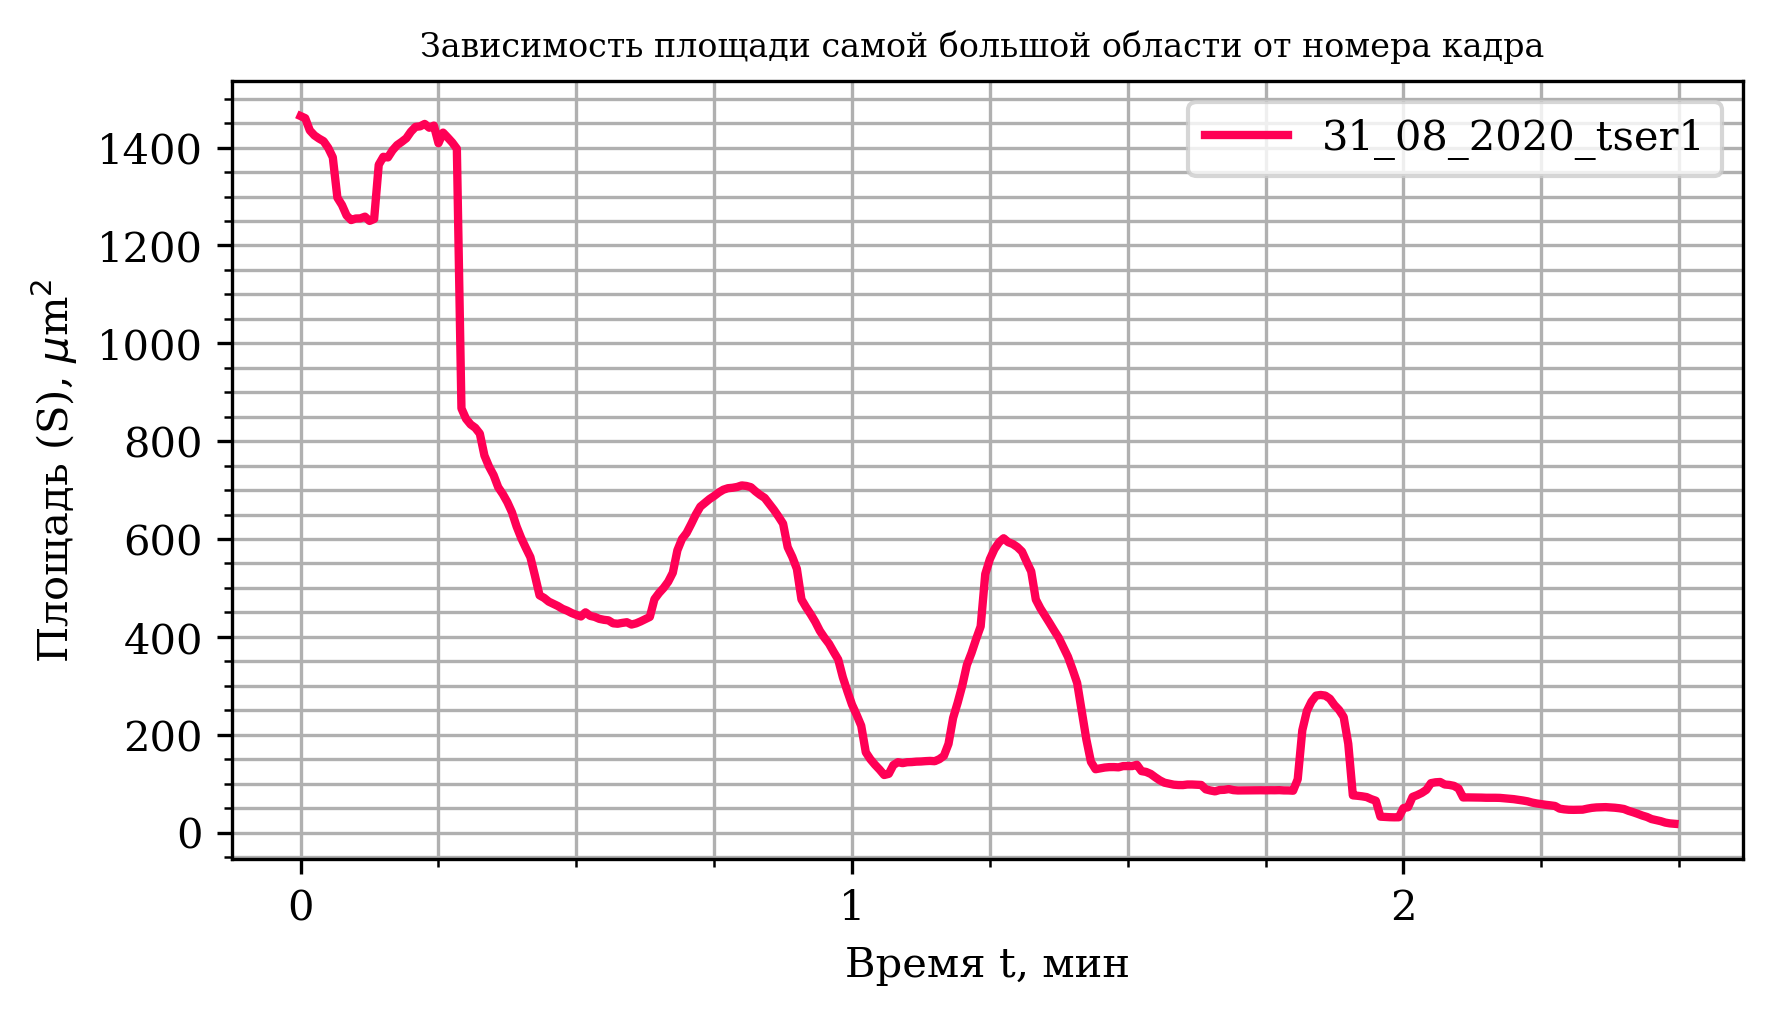

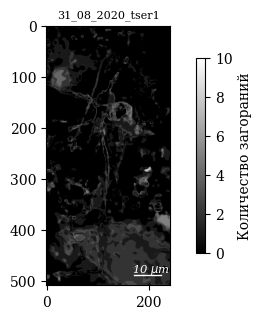

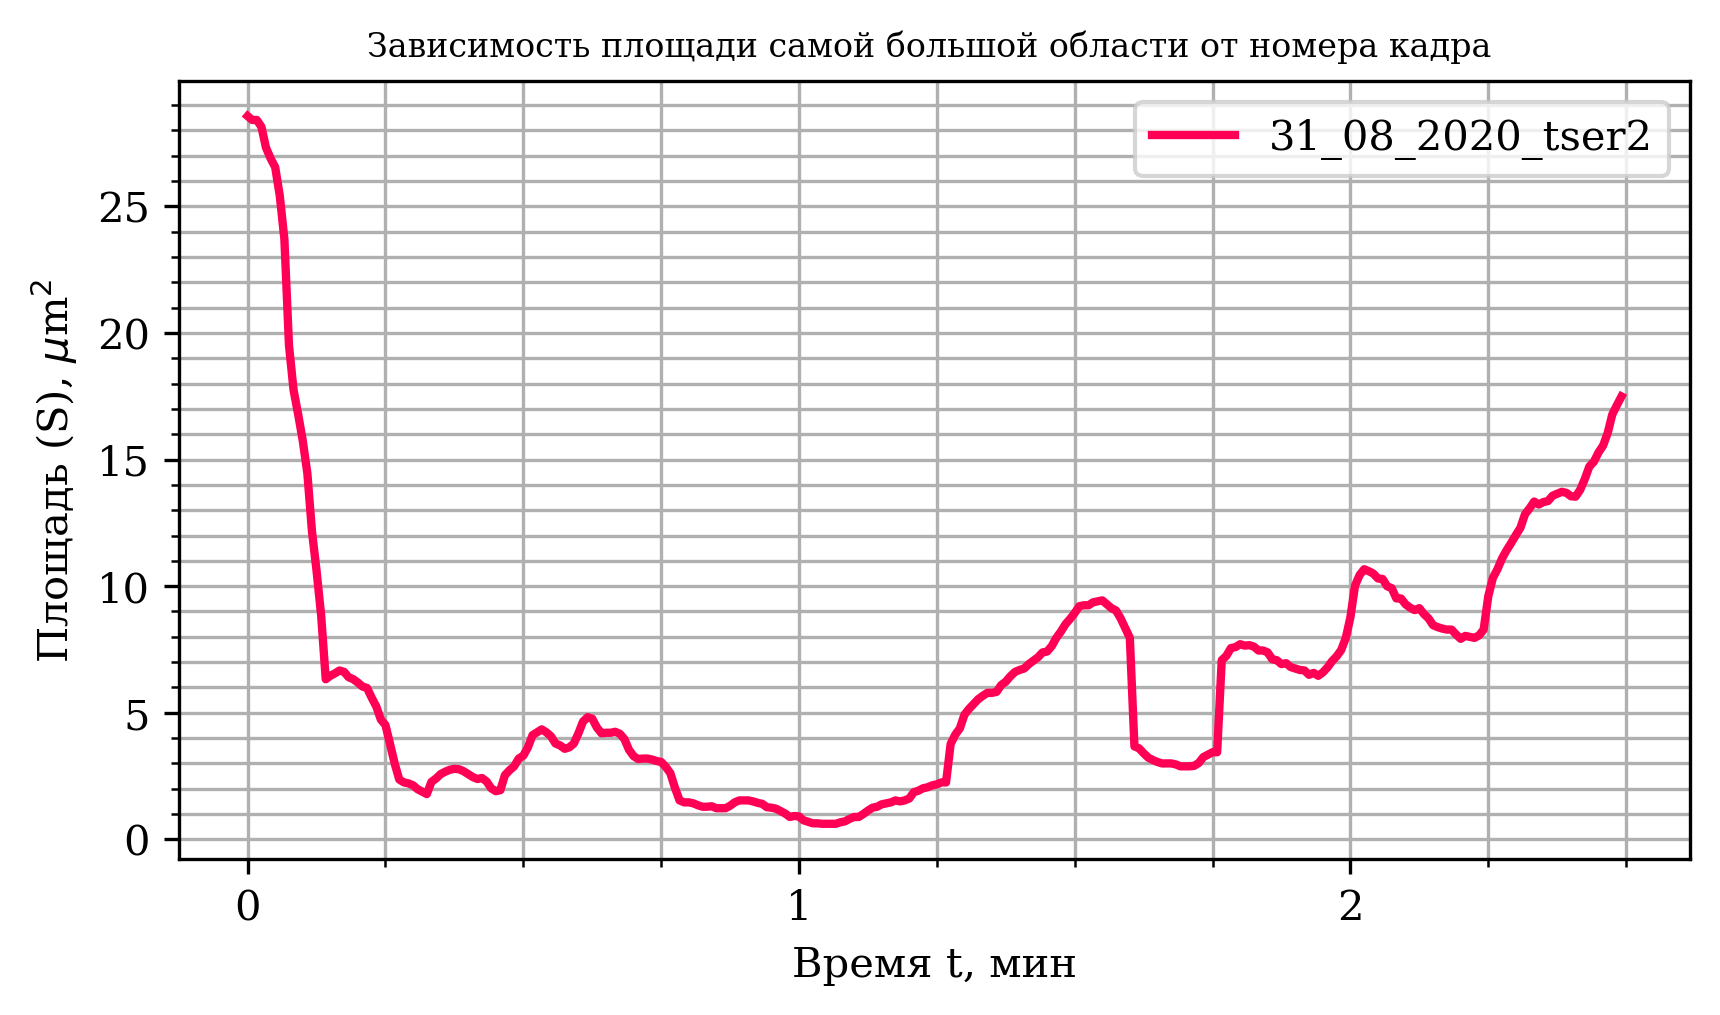

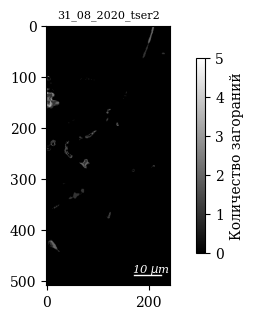

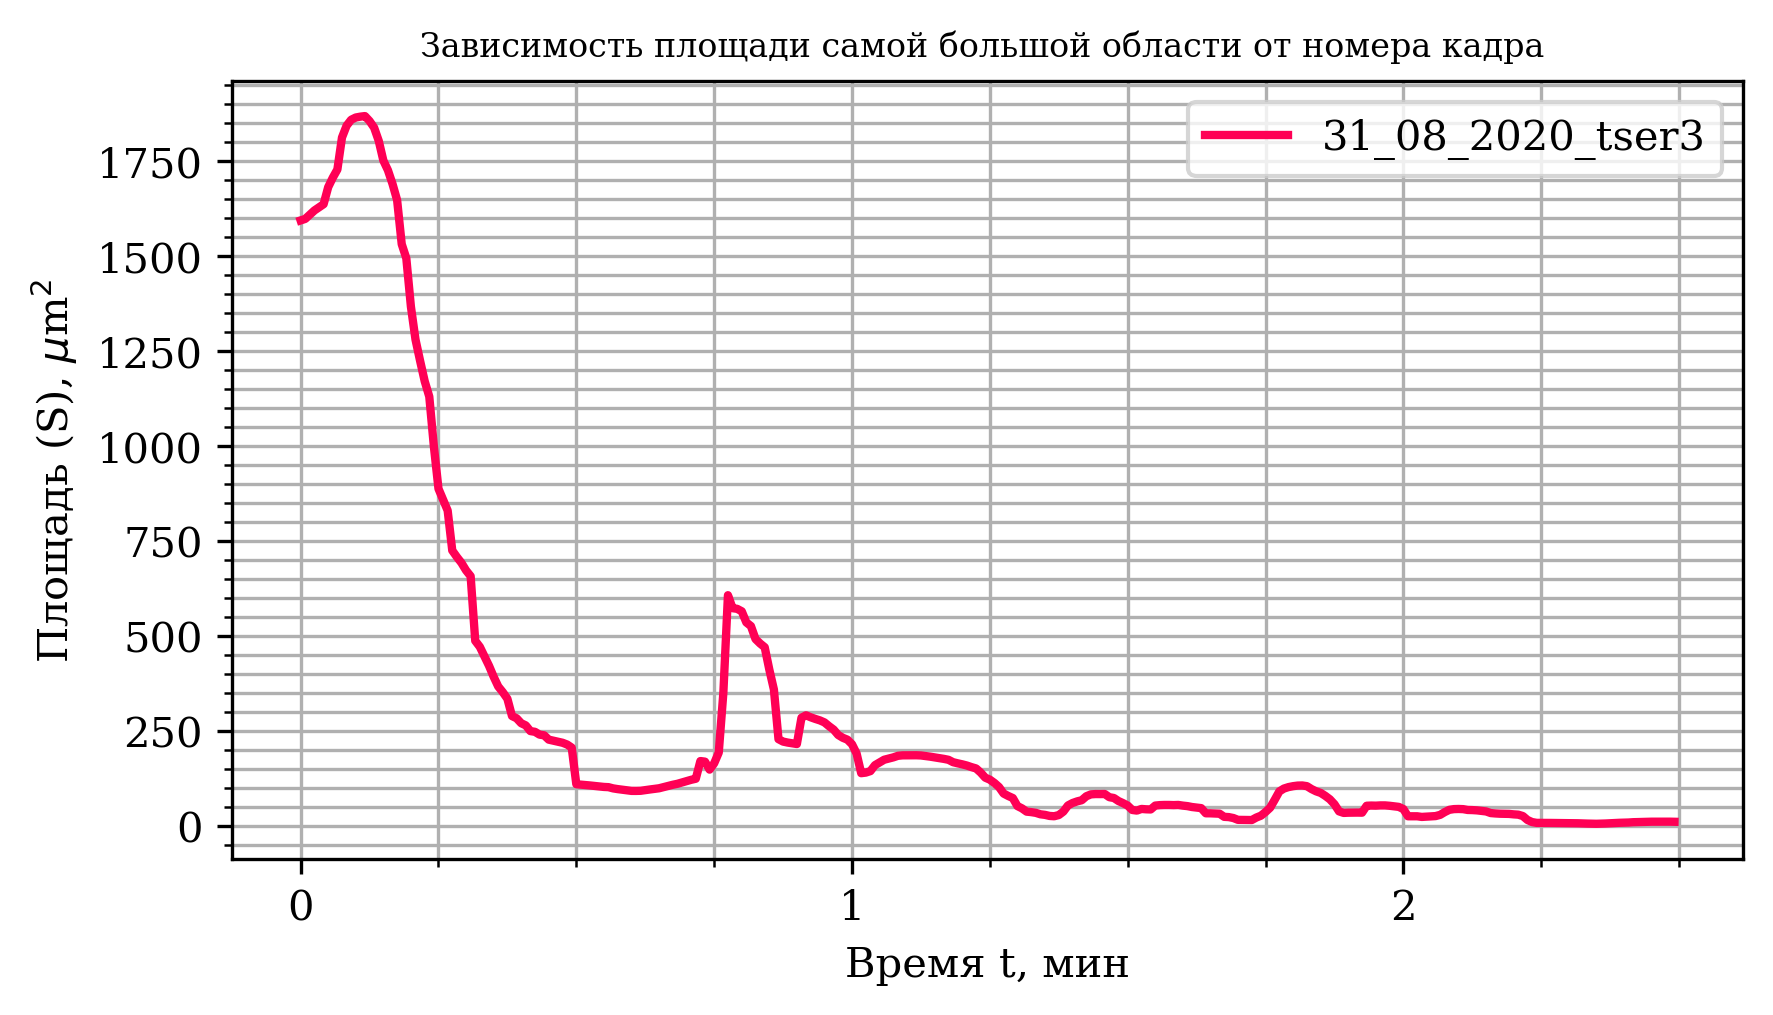

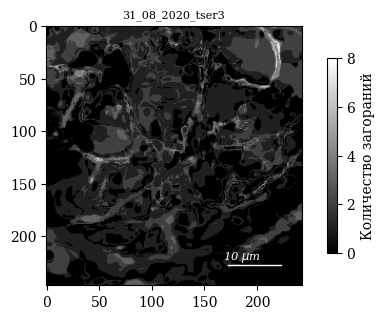

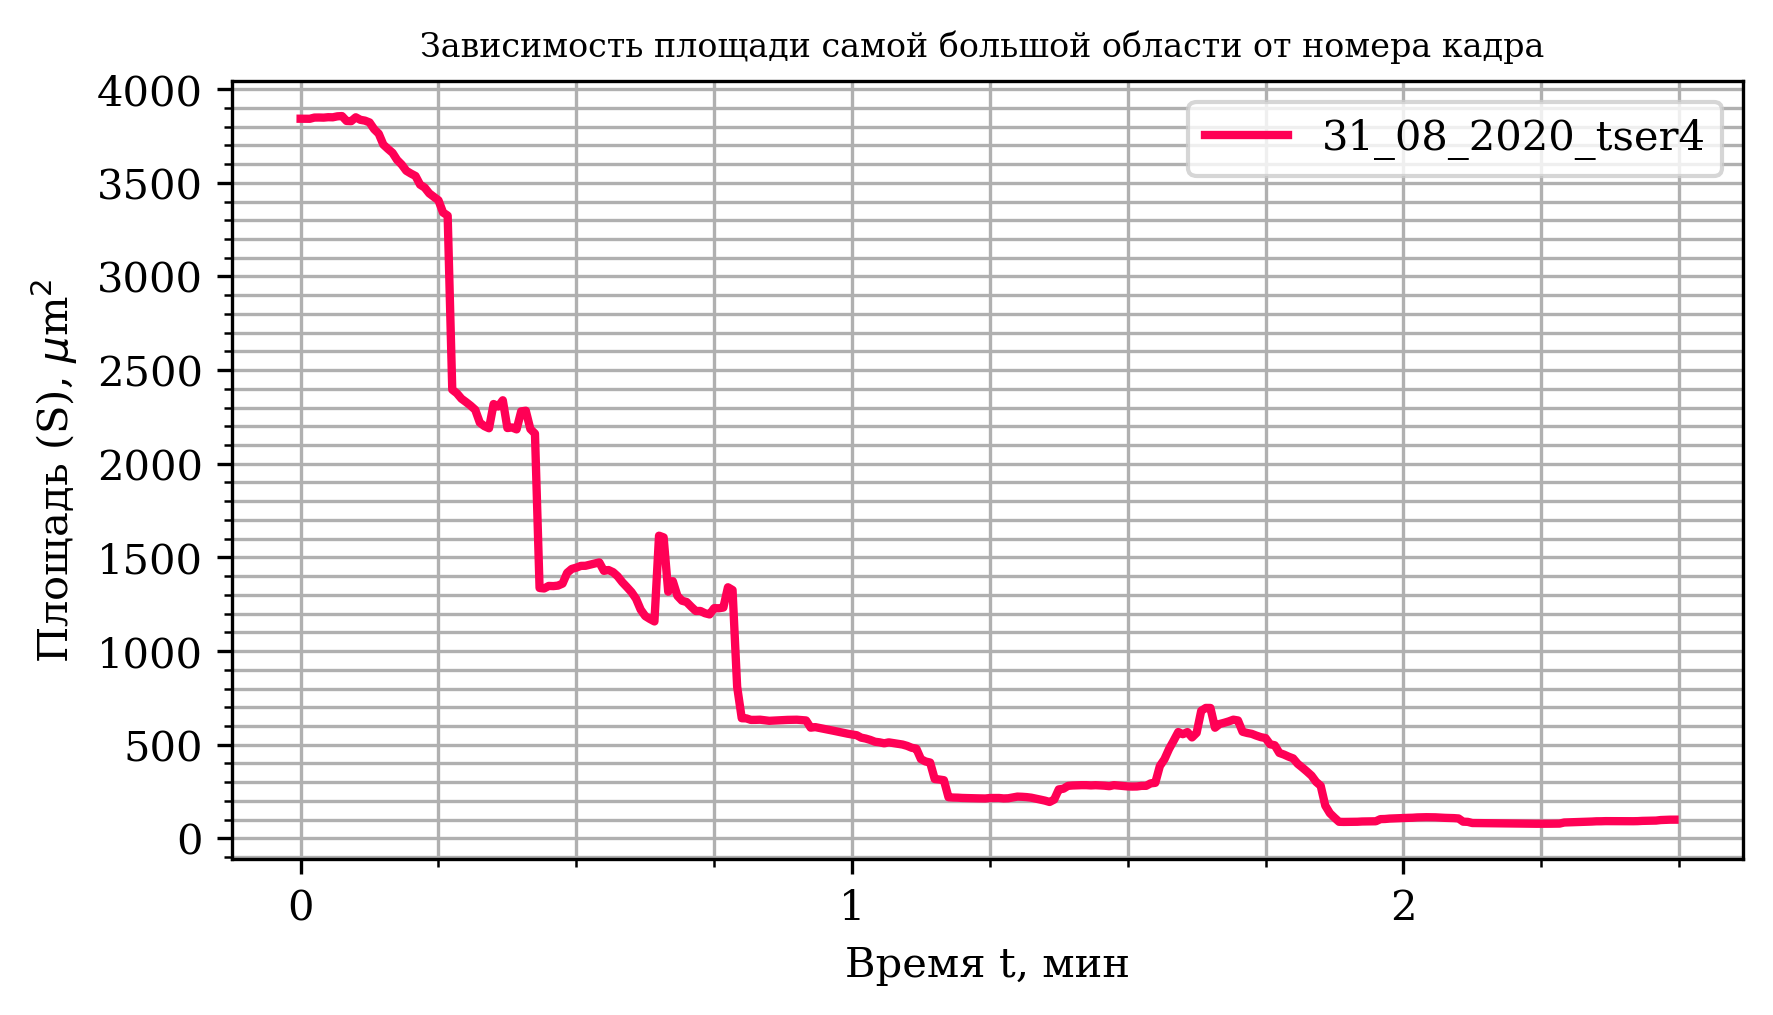

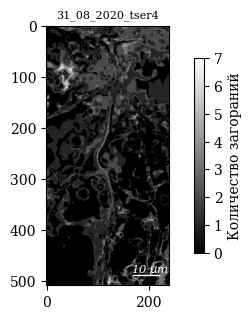

In [19]:
mask = Path(r'C:/nn/Task_Astrocytes/Task_Astrocytes') / '**'/ '**' / 'events'/ '***.png'
dir_folders = r'C:/nn/Task_Astrocytes/Task_Astrocytes'
full_processing.analizes_full(mask, dir_folders, data_dir_save=r'C:/Users/sibir/Desktop/results')

[https://cloud.unn.ru/s/cxzFm54qWdg4moc/download/отчет_астроциты.docx]

[https://github.com/Mishchenko754/congenial-spork.git]